In [14]:
## Get dependencies ##

import numpy as np
import string
import math
import sys
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sn
from UnFaIR import *
import scipy as sp
import pickle
import time
import scipy as sp
from scipy import ndimage
from scipy import signal
import os
import netCDF4
from difflib import SequenceMatcher
import statsmodels.api as sm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

# Emissions to Concentrations

## Get Data

### Attributable warming

/home/leachl/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  # Remove the CWD from sys.path while we load stuff.


Integrating 1 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['CO2', 'CH4', 'N2O'], between 1750 and 2019...
Integrating 1 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['CO2', 'CH4', 'N2O'], between 1750 and 2019...


/home/leachl/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/home/leachl/miniconda3/lib/python3.7/site-packages/pandas/plotting/_core.py:185: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


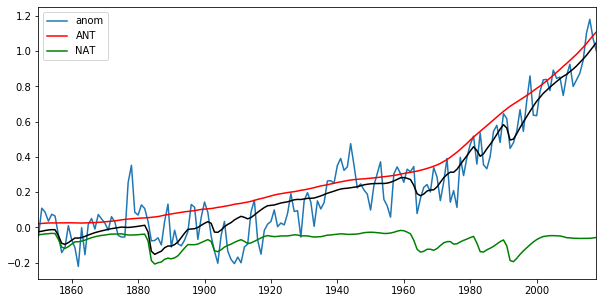

In [15]:
## Get 4 dataset mean temps:

base_fname = '/home/leachl/Documents/Datasets/GMST/HadCRUT.4.6.0.0.monthly_ns_avg_realisations/HadCRUT.4.6.0.0.monthly_ns_avg.'

HadCRUT4_ens_df = pd.DataFrame(index = np.arange(1850+1/12,2019+4/12+0.001,1/12)-1/24,columns = np.arange(1,101))

for i in np.arange(1,101):
    member = str(i)
    fname = base_fname + member + '.txt'
    hadcrut_mem_df = pd.read_csv(fname,sep='   ',header=None)
    temps = hadcrut_mem_df[1].values
    HadCRUT4_ens_df.loc[:,i] = temps
    
temp_base = '/home/leachl/Documents/Datasets/GMST'
CW_temps = pd.read_csv(temp_base+'/CW_had4_krig_v2_0_0.txt',delim_whitespace=True,header=None,index_col=0,names=['Year','anom','tot_uc','cov_uc','ens_uc']).set_index(HadCRUT4_ens_df.index[:-1]).anom
NOAA_temps = pd.read_csv(temp_base+'/NOAA_1880-2019.csv',skiprows=4,index_col=0).set_index(HadCRUT4_ens_df.loc[1880:].index).Value
GISS_temps = pd.read_csv(temp_base+'/nasa_GLB.Ts+dSST.txt',skiprows=7,delim_whitespace=True,index_col=0).iloc[:2019,:12]
GISS_temps = GISS_temps.loc[:'2019'].loc[GISS_temps.loc[:'2019'].index != "Year"].values.flatten()[:-8]
GISS_temps = pd.Series(GISS_temps.astype(float),index = NOAA_temps.index)/100
ALL_temps = pd.DataFrame(index = HadCRUT4_ens_df.index,columns=['anom'])
HC_mem = HadCRUT4_ens_df.median(axis=1)
HC_mem = HC_mem - HC_mem.loc[1850:1900].mean()
CW_mem = CW_temps - CW_temps.loc[1850:1900].mean()
NOAA_mem = NOAA_temps - (NOAA_temps.loc[1880:2017].mean() - HC_mem.loc[1880:2017].mean())
GISS_mem = GISS_temps - (GISS_temps.loc[1880:2017].mean() - HC_mem.loc[1880:2017].mean())
ALL_temps.loc[:,'anom'] = (1/4)*(HC_mem+CW_mem+NOAA_mem+GISS_mem)
ALL_temps.loc[1850:1880,'anom'] = (1/2)*(HC_mem.loc[1850:1880]+CW_mem.loc[1850:1880])
ALL_temps = ALL_temps.loc[:2019]
Annual_4_set_GMST = ALL_temps.rolling(12).mean().iloc[11::12].set_index(np.arange(1850,2019))
                                                                        
fig,ax = plt.subplots(figsize=(10,5))
Annual_4_set_GMST.plot(ax=ax)

HIST_forc_PF = pd.read_csv('/home/leachl/Documents/Datasets/RF/AR5Forcing_ext2015_GHGrevised.txt',skiprows=3,sep='\t',index_col=0).apply(pd.to_numeric)
HIST_forc_PF.iloc[-3:,:] = pd.read_csv('/home/leachl/Documents/Datasets/RF/AR5Forcing_ext2015_GHGrevised.txt',skiprows=271,header=None,delim_whitespace=True,index_col=0).values
HIST_forc_PF = HIST_forc_PF.set_index(np.arange(1750,2020))
HIST_forc_PF['Natural total'] = HIST_forc_PF['Total'] - HIST_forc_PF['Anthro total']

def convert_forc_to_model_input(forcing,scen_name,inner_name='forcing'):
    return pd.concat([pd.DataFrame(forcing.rename(inner_name))],axis=1,keys=[scen_name])

Attr_thermal_params = default_thermal_params()
Attr_thermal_params.loc['tcr_ecs'] = [1.6,2.8]

ANT_temps = run_UnFaIR(emissions_in=return_empty_emissions(convert_forc_to_model_input(HIST_forc_PF['Anthro total'],'Attr_warming')),\
                     forcing_in=convert_forc_to_model_input(HIST_forc_PF['Anthro total'],'Attr_warming'),\
                    thermal_parameters=tcr_ecs_to_q(Attr_thermal_params))['T'].iloc[:,0]

NAT_temps = run_UnFaIR(emissions_in=return_empty_emissions(convert_forc_to_model_input(HIST_forc_PF['Anthro total'],'Attr_warming')),\
                     forcing_in=convert_forc_to_model_input(HIST_forc_PF['Natural total'],'Attr_warming'),\
                    thermal_parameters=tcr_ecs_to_q(Attr_thermal_params))['T'].iloc[:,0]

Y = Annual_4_set_GMST.copy()
X = pd.concat([ANT_temps.rename('ANT'),NAT_temps.rename('NAT')],axis=1)
X = sm.add_constant(X)

regression_model = sm.OLS(Y,X.loc[Y.index])
regression_results = regression_model.fit()
(regression_results.params*X.loc[Y.index])[['ANT','NAT']].plot(ax=ax,colors=['r','g'])
(regression_results.params*X.loc[Y.index]).sum(axis=1).plot(ax=ax,colors='k')

## Attributable warming:

Attributable_warming = (regression_results.params*X).sum(axis=1) - (regression_results.params*X).sum(axis=1).iloc[0]

### Primap-HIST and Global Carbon Project emissions

In [16]:
# CO2 from GCP

GCP_CO2_data = pd.read_excel('/home/leachl/Documents/Datasets/Emissions/Global_carbon_budget/Global_Carbon_Budget_2018v1.0.xlsx',-1,skiprows=14,index_col=0)
GCP_CO2_data.iloc[0,:2] = 0
CO2_emms = GCP_CO2_data.interpolate(method='linear').iloc[:,:2].sum(axis=1).rename('CO2')

# CH4 from PRIMAP-hist

PRIMAP_hist=pd.read_csv('/home/leachl/Documents/Datasets/Emissions/PRIMAP-hist/PRIMAP-hist_v2.0_11-Dec-2018/PRIMAP-hist_v2.0_11-Dec-2018.csv')
CH4_emms = PRIMAP_hist.loc[(PRIMAP_hist.country == 'EARTH')&(PRIMAP_hist.scenario=='HISTTP')&(PRIMAP_hist.entity=='CH4')&(PRIMAP_hist.category=='IPCM0EL')].iloc[:,5:].T.apply(pd.to_numeric)
CH4_emms.columns = ['CH4']
CH4_emms = CH4_emms.set_index(np.arange(1850,2017)).reindex(np.arange(1750,2017))
CH4_emms.loc[:1849] = np.linspace(0,0.99,100)[:,np.newaxis] * CH4_emms.loc[1850].values

# N2O from PRIMAP_hist

N2O_emms = PRIMAP_hist.loc[(PRIMAP_hist.country == 'EARTH')&(PRIMAP_hist.scenario=='HISTTP')&(PRIMAP_hist.entity=='N2O')&(PRIMAP_hist.category=='IPCM0EL')].iloc[:,5:].T.apply(pd.to_numeric)
N2O_emms.columns = ['N2O']
N2O_emms = N2O_emms.set_index(np.arange(1850,2017)).reindex(np.arange(1750,2017))
N2O_emms.loc[:1849] = np.linspace(0,0.99,100)[:,np.newaxis] * N2O_emms.loc[1850].values

# Combine
Best_emission_estimates = pd.concat([pd.concat([CO2_emms,CH4_emms/1000,N2O_emms*28/44000],axis=1)],keys=['default'],axis=1)

### CMIP6 plus NOAA extension concentrations

In [17]:
#(linearly scaling NOAA to match CMIP6 - not by a lot)

CMIP6_concs = pd.read_csv('/home/leachl/Documents/Datasets/Concentrations/Supplementary_Table_UoM_GHGConcentrations-1-1-0_annualmeans_v23March2017.csv',skiprows=21,index_col=0)
CMIP6_concs_extended = CMIP6_concs.loc[:,['CO2','CH4','N2O']].reindex(np.arange(1500,2019))

NOAA_concs = pd.read_csv('/home/leachl/Documents/Datasets/Concentrations/NOAA_MoleFractions_2019.csv',skiprows=2,index_col=0)
NOAA_concs = NOAA_concs.iloc[1:-5].loc[:,['CO2','CH4','N2O']].apply(pd.to_numeric).set_index(np.arange(1979,2019))

CMIP6_concs_extended.loc[2015:] = NOAA_concs.loc[2015:] * CMIP6_concs.loc[2014,['CO2','CH4','N2O']] / NOAA_concs.loc[2014]

### RCP data

In [18]:
RCP_data = {}
RCP_data['RF'] = {}
RCP_data['C'] = {}
RCP_data['E'] = {}

for RCP in ['3PD','45','6','85']:
    RCP_data['C'][RCP] = pd.read_csv('/home/leachl/Documents/Datasets/RCP_data/RCP'+RCP+'_MIDYEAR_CONCENTRATIONS.csv',skiprows=37,index_col=0).loc[np.arange(1765,2151)]
    RCP_data['RF'][RCP] = pd.read_csv('/home/leachl/Documents/Datasets/RCP_data/RCP'+RCP+'_MIDYEAR_RADFORCING.csv',skiprows=58,index_col=0)
    RCP_data['E'][RCP] = pd.read_csv('/home/leachl/Documents/Datasets/RCP_data/RCP'+RCP+'_EMISSIONS.csv',skiprows=36,index_col=0).loc[:2150]

## CO2

r0: 28.627295652588344
rT: 4.334432931036162
rC: 0.01977292333485884


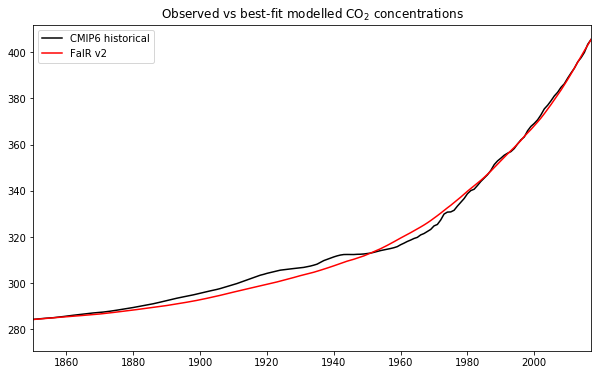

In [19]:
# Method:
# Using attributable warming plus GCP emissions
# Fit r0 and rT / rC (fixed ratio) to present day concentrations

fit_time_period = list(set(Best_emission_estimates['default','CO2'].dropna().index).intersection(set(Attributable_warming.index)))

CO2_fit_warming = Attributable_warming.loc[fit_time_period].values.flatten()
CO2_fit_emissions = convert_forc_to_model_input(Best_emission_estimates['default','CO2'],'fit_CO2','CO2')

CO2_original_parameters = convert_forc_to_model_input(default_gas_forcing_params()['default','CO2'],'tune_CO2','CO2')

def fit_CO2_params(x,fit_time):
    
    fit_params = CO2_original_parameters.copy()
    rT_rC_scaling = 0.019/4.165
    fit_params.loc[['r0','rT','rC'],('tune_CO2','CO2')] = [ x[0] , x[1] , x[1] * rT_rC_scaling ]
    
    fit_model_run = prescribed_temps_gas_cycle(T=CO2_fit_warming,emissions_in=CO2_fit_emissions,gas_parameters=fit_params)['C'].loc[fit_time,('fit_CO2','tune_CO2','CO2')]
    
    return np.sum((CMIP6_concs_extended.loc[fit_time,'CO2'] - fit_model_run)**2)

fit_result = sp.optimize.minimize(fit_CO2_params,x0=[32,4.165],args=2017,method='Nelder-mead')

fig,ax = plt.subplots(figsize=(10,6))
ax.plot(CMIP6_concs_extended.loc[fit_time_period,'CO2'],'k',label='CMIP6 historical')
tuned_params = CO2_original_parameters.copy()
rT_rC_scaling = 0.019/4.165
tuned_params.loc[['r0','rT','rC'],('tune_CO2','CO2')] = [ fit_result.x[0] , fit_result.x[1] , fit_result.x[1] * rT_rC_scaling ]
tuned_model_run = prescribed_temps_gas_cycle(T=CO2_fit_warming,emissions_in=CO2_fit_emissions,gas_parameters=tuned_params)['C'].loc[fit_time_period]
ax.plot(tuned_model_run,'r',label='FaIR v2')
plt.xlim(1850,2017)
plt.title('Observed vs best-fit modelled CO$_2$ concentrations')
plt.legend()

print('r0:',fit_result.x[0])
print('rT:',fit_result.x[1])
print('rC:',fit_result.x[1] * rT_rC_scaling)

## CH4

### Sensitivities (Prather)

In [20]:
## Linearise about 2010 values (perturb by small quantity), convert to FaIRv2 sensitivities

def calculate_prather_CH4_life(T,C,sT=-3,sMR=-0.32,sC=0.31,a1=0.94,a2=1.5):
    
    atmos_temp = 251.9 + a1 * (T - T.loc[2010])
    
    sat_vap_pressure =  6.112*(np.exp(6816*(1/273.15 - 1/atmos_temp) + 5.1309 * np.log(273.15/atmos_temp)))
    
    MR,T = 2.45 * (1 + a2 * (sat_vap_pressure - sat_vap_pressure.loc[2010]) / sat_vap_pressure.loc[2010]) , atmos_temp
    
    feedback = (T/T.loc[2010]) ** sT * (MR / MR.loc[2010]) ** sMR * (C / C.loc[2010]) ** sC
    
    return ( (11.2*feedback)**-1 + 1/150 + 1/120 + 1/200 ) ** (-1)

T_2010_perturb = pd.DataFrame([Attributable_warming.loc[2010],Attributable_warming.loc[2010]+0.01],index=[2010,'delta'])
T_2010_const = pd.DataFrame([Attributable_warming.loc[2010],Attributable_warming.loc[2010]],index=[2010,'delta'])

C_2010_perturb = pd.DataFrame([CMIP6_concs_extended.loc[2010,'CH4'],CMIP6_concs_extended.loc[2010,'CH4']+0.01],index=[2010,'delta'])
C_2010_const = pd.DataFrame([CMIP6_concs_extended.loc[2010,'CH4'],CMIP6_concs_extended.loc[2010,'CH4']],index=[2010,'delta'])

linearise_T = calculate_prather_CH4_life(T_2010_perturb,C_2010_const)[0]
linearise_C = calculate_prather_CH4_life(T_2010_const,C_2010_perturb)[0]

tau_2010 = linearise_T.loc[2010]    
g1 = tau_2010 * ( 1. - ( 1. + 100/tau_2010 ) * np.exp(-100/tau_2010) )
g0 = ( np.sinh( tau_2010 * ( 1. - np.exp(-100/tau_2010) )  / g1 ) )**(-1.)
linearised_coeff = ( ( g0/g1 ) * np.cosh((np.arcsinh(1/g0))) )

print('rT best estimate:',( linearise_T.loc['delta'] - linearise_T.loc[2010] ) / (0.01 * linearise_T.loc[2010] * linearised_coeff))

print('rA best estimate:',( linearise_C.loc['delta'] - linearise_C.loc[2010] ) * 0.3517 / (0.01 * linearise_C.loc[2010] * linearised_coeff))

rT best estimate: -0.287224217280051
rA best estimate: 0.00034332334919596834


In [21]:
## Monte carlo sample for the uncertainties:

N = 5000

rT_distr = np.zeros(N)
rC_distr = np.zeros(N)

C_2010_perturb = pd.DataFrame([CMIP6_concs_extended.loc[2010,'CH4'],CMIP6_concs_extended.loc[2010,'CH4']+0.01],index=[2010,'delta'])
C_2010_const = pd.DataFrame([CMIP6_concs_extended.loc[2010,'CH4'],CMIP6_concs_extended.loc[2010,'CH4']],index=[2010,'delta'])
    
for i in np.arange(N):

    sT= np.random.normal(-3,0.8)
    sMR= np.random.normal(-0.32,0.03)
    sC= np.random.normal(0.31,0.04)
    a1= np.random.normal(0.94,0.1)
    a2= np.random.normal(1.5,0.1)

    sample_attributable_warming_2010 = Attributable_warming.loc[2010] * np.random.normal(1,0.2)

    T_2010_perturb = pd.DataFrame([sample_attributable_warming_2010,sample_attributable_warming_2010+0.01],index=[2010,'delta'])
    T_2010_const = pd.DataFrame([sample_attributable_warming_2010,sample_attributable_warming_2010],index=[2010,'delta'])
    
    linearise_T = calculate_prather_CH4_life(T_2010_perturb,C_2010_const,sT=sT,sMR=sMR,sC=sC,a1=a1,a2=a2)[0]
    linearise_C = calculate_prather_CH4_life(T_2010_const,C_2010_perturb,sT=sT,sMR=sMR,sC=sC,a1=a1,a2=a2)[0]
    
    tau_2010 = linearise_T.loc[2010]    
    g1 = tau_2010 * ( 1. - ( 1. + 100/tau_2010 ) * np.exp(-100/tau_2010) )
    g0 = ( np.sinh( tau_2010 * ( 1. - np.exp(-100/tau_2010) )  / g1 ) )**(-1.)
    linearised_coeff = ( ( g0/g1 ) * np.cosh((np.arcsinh(1/g0))) )
    
    rT_distr[i] = ( linearise_T.loc['delta'] - linearise_T.loc[2010] ) / (0.01 * linearise_T.loc[2010] * linearised_coeff)
    rC_distr[i] = ( linearise_C.loc['delta'] - linearise_C.loc[2010] ) * 0.3517 / (0.01 * linearise_C.loc[2010] * linearised_coeff)

Text(0.5, 1.0, 'rC distribution (MC sample) = N[0.000342, 4.4e-05]')

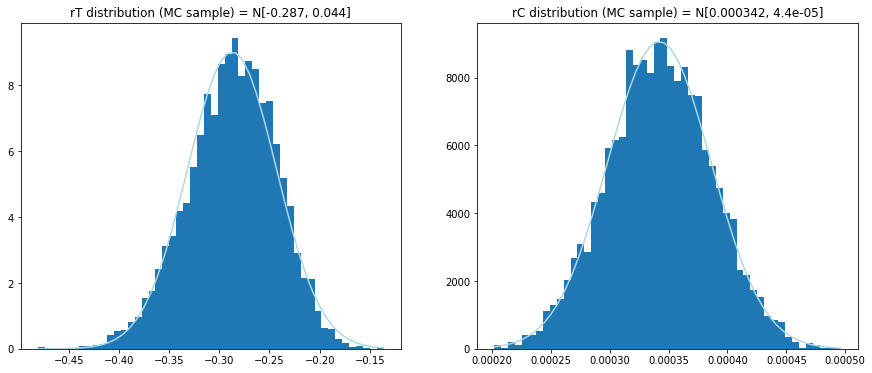

In [22]:
rT_norm_params = sp.stats.norm.fit(rT_distr)
rC_norm_params = sp.stats.norm.fit(rC_distr)

xrange_rT = np.linspace(rT_distr.min(),rT_distr.max())
xrange_rC = np.linspace(rC_distr.min(),rC_distr.max())
    
fig,ax = plt.subplots(1,2,figsize=(15,6))
ax[0].hist(rT_distr,bins=50,density=True)
ax[0].plot(xrange_rT,sp.stats.norm.pdf(xrange_rT,*rT_norm_params),'lightblue')
ax[0].set_title('rT distribution (MC sample) = N'+str([round(x,3) for x in rT_norm_params]))
ax[1].hist(rC_distr,bins=50,density=True)
ax[1].plot(xrange_rC,sp.stats.norm.pdf(xrange_rC,*rC_norm_params),'lightblue')
ax[1].set_title('rC distribution (MC sample) = N'+str([round(x,6) for x in rC_norm_params]))

In [23]:
## Normal percentage uncertainties:

print('rT best estimate: -0.287224217280051 +/- '+str(100*0.044/0.287224217280051)+'%')
print('rA best estimate: 0.00034332334919596834 +/- '+str(100*4.4e-05/0.00034332334919596834)+'%')

rT best estimate: -0.287224217280051 +/- 15.319042529446207%
rA best estimate: 0.00034332334919596834 +/- 12.815906667298904%


### r0 plus PI_conc to historical concentrations

r0: 9.078873796236861
PI_conc: 733.8220807659225


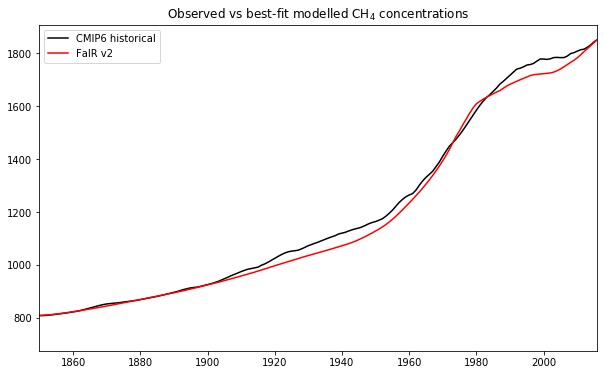

In [24]:
# Method:
# Using attributable warming plus Primap-HIST emissions
# Fit r0 and PI_conc to present day concentrations

fit_time_period = list(set(Best_emission_estimates['default','CH4'].dropna().index).intersection(set(Attributable_warming.index)))

CH4_fit_warming = Attributable_warming.loc[fit_time_period].values.flatten()
CH4_fit_emissions = convert_forc_to_model_input(Best_emission_estimates['default','CH4'].dropna(),'fit_CH4','CH4')

CH4_original_parameters = convert_forc_to_model_input(default_gas_forcing_params()['default','CH4'],'tune_CH4','CH4')
CH4_original_parameters.loc[['rT','rA'],('tune_CH4','CH4')] = [-0.287,0.000343]

def fit_CH4_params(x,fit_time,mode='absolute'):
    
    fit_params = CH4_original_parameters.copy()
    fit_params.loc[['r0','PI_conc'],('tune_CH4','CH4')] = [ x[0] , x[1] ]
    
    if mode == 'absolute':
    
        fit_model_run = prescribed_temps_gas_cycle(T=CH4_fit_warming,emissions_in=CH4_fit_emissions,gas_parameters=fit_params)['C'].loc[fit_time,('fit_CH4','tune_CH4','CH4')]

        return np.sum((CMIP6_concs_extended.loc[fit_time,'CH4'] - fit_model_run)**2)
                      
    if mode == 'difference':
        
        fit_model_run = prescribed_temps_gas_cycle(T=CH4_fit_warming,emissions_in=CH4_fit_emissions,gas_parameters=fit_params)['C'].diff().loc[fit_time,('fit_CH4','tune_CH4','CH4')]

        return np.sum((CMIP6_concs_extended.diff().loc[fit_time,'CH4'] - fit_model_run)**2)

fit_result = sp.optimize.minimize(fit_CH4_params,x0=[9,720],args=(2016),method='Nelder-mead')

fig,ax = plt.subplots(figsize=(10,6))
ax.plot(CMIP6_concs_extended.loc[fit_time_period,'CH4'],'k',label='CMIP6 historical')
tuned_params = CH4_original_parameters.copy()
tuned_params.loc[['r0','PI_conc'],('tune_CH4','CH4')] = [ fit_result.x[0] , fit_result.x[1] ]
tuned_model_run = prescribed_temps_gas_cycle(T=CH4_fit_warming,emissions_in=CH4_fit_emissions,gas_parameters=tuned_params)['C'].loc[fit_time_period]
ax.plot(tuned_model_run,'r',label='FaIR v2')
plt.title('Observed vs best-fit modelled CH$_4$ concentrations')
plt.xlim(1850,2016)
plt.legend()

print('r0:',fit_result.x[0])
print('PI_conc:',fit_result.x[1])

#### alternative inverse method r0 fit to Global Methane Budget

In [25]:
# Method:
# Using attributable warming plus Primap-HIST emissions
# Fit r0 and PI_conc to present day concentrations

fit_time_period = list(set(Best_emission_estimates['default','CH4'].dropna().index).intersection(set(Attributable_warming.index)))

CH4_fit_warming = Attributable_warming.loc[1750:2018].values.flatten()[np.newaxis,np.newaxis,np.newaxis,:]

original_params = default_gas_forcing_params()

original_params.loc['PI_conc',('default','CH4')] = 720.0

a = input_to_numpy(original_params.loc['a1':'a4'])[np.newaxis,:,np.newaxis,...]
tau = input_to_numpy(original_params.loc['tau1':'tau4'])[np.newaxis,:,np.newaxis,...]
emis2conc = original_params.loc['emis2conc'].values.reshape(original_params.loc['emis2conc'].index.levels[0].size,original_params.loc['emis2conc'].index.levels[1].size)[np.newaxis,:,np.newaxis,...]
PI_conc = original_params.loc['PI_conc'].values.reshape(original_params.loc['PI_conc'].index.levels[0].size,original_params.loc['PI_conc'].index.levels[1].size)[np.newaxis,:,np.newaxis,...]

def fit_CH4_params_inverse(x,GMB_method = 'td'):
    
    ## GMB_method = top-down (td) or bottom-up (bu)
    
    GMB_results = {'td':357,'bu':366}
    
    r = input_to_numpy(original_params.loc['r0':'rA'])[np.newaxis,:,np.newaxis,...]
    
    r[0,0,0,1,0] = x
    
    inverse_emissions = unstep_concentration(CMIP6_concs_extended.loc[1750:2018].T.values[np.newaxis,np.newaxis,np.newaxis,:], CH4_fit_warming, a, tau, r, PI_conc, emis2conc, timestep=np.ones(CH4_fit_warming.shape[-1]), concentration_driven = False)[0][0,0,0,1,:]
        
    return (np.mean(inverse_emissions[-11:-1]) - GMB_results[GMB_method])**2

print('With pre-industrial concentrations set to 720 for consistency with CMIP6 historical concentrations:')
print('r0 (top-down):',sp.optimize.minimize(fit_CH4_params_inverse,x0=9,args='td',method='Nelder-mead').x[0])
print('r0 (bottom-up):',sp.optimize.minimize(fit_CH4_params_inverse,x0=9,args='bu',method='Nelder-mead').x[0])

With pre-industrial concentrations set to 720 for consistency with CMIP6 historical concentrations:
r0 (top-down): 8.44464111328125
r0 (bottom-up): 8.261004638671876


## N2O

### Sensitivities (prather)

In [26]:
## N2O is fully linear in Prather ie. the linear coefficient at 2005:2010 is -0.065 with a lifetime of 116 over this period

tau_N2O = 116

g1 = tau_N2O * ( 1. - ( 1. + 100/tau_N2O ) * np.exp(-100/tau_N2O) )
g0 = ( np.sinh( tau_N2O * ( 1. - np.exp(-100/tau_N2O) )  / g1 ) )**(-1.)

print('rA best estimate:', (-0.065/CMIP6_concs_extended.loc[2005:2010,'N2O'].mean()) / ( ( g0/g1 ) * np.cosh((np.arcsinh(1/g0))) ) * (1/((5.148*10**18/1e18*28)/28.97)) )

rA best estimate: -0.0009993402132191626


In [27]:
N = 5000

rA_distr = np.zeros(N)

for i in np.arange(N):

    tau_sample = np.random.normal(116,9)

    g1 = tau_sample * ( 1. - ( 1. + 100/tau_sample ) * np.exp(-100/tau_sample) )
    g0 = ( np.sinh( tau_sample * ( 1. - np.exp(-100/tau_sample) )  / g1 ) )**(-1.)
    
    sC = np.random.normal(-0.065,0.010)

    rA_distr[i] = (sC/CMIP6_concs_extended.loc[2005:2010,'N2O'].mean()) / ( ( g0/g1 ) * np.cosh((np.arcsinh(1/g0))) ) * (1/((5.148*10**18/1e18*28)/28.97))

Text(0.5, 1.0, 'rA distribution (MC sample) = N[-0.001, 0.00015]')

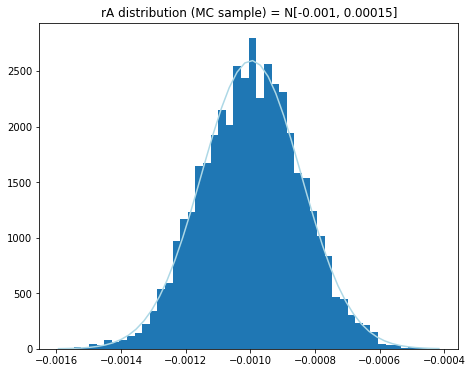

In [28]:
rA_norm_params = sp.stats.norm.fit(rA_distr)

xrange_rA = np.linspace(rA_distr.min(),rA_distr.max())
    
fig,ax = plt.subplots(1,figsize=(7.5,6))
ax.hist(rA_distr,bins=50,density=True)
ax.plot(xrange_rA,sp.stats.norm.pdf(xrange_rA,*rA_norm_params),'lightblue')
ax.set_title('rA distribution (MC sample) = N'+str([round(x,5) for x in rA_norm_params]))

In [29]:
# Normal percentage uncertaintes:

print('rA best estimate: -0.0009993402132191626 +/- '+str(100*0.00016/0.0009993402132191626)+'%')

rA best estimate: -0.0009993402132191626 +/- 16.01056355818945%


### r0 plus PI_conc to historical concentrations

r0: 67.84335607673184
PI_conc: 271.25849213596996


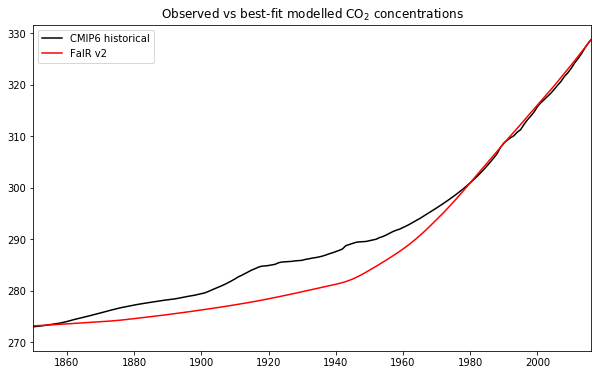

In [30]:
# Method:
# Using attributable warming plus Primap-HIST emissions
# Fit r0 and PI_conc to present day concentrations

fit_time_period = list(set(Best_emission_estimates['default','N2O'].dropna().index).intersection(set(Attributable_warming.index)))

N2O_fit_warming = Attributable_warming.loc[fit_time_period].values.flatten()
N2O_fit_emissions = convert_forc_to_model_input(Best_emission_estimates['default','N2O'].dropna(),'fit_N2O','N2O')

N2O_original_parameters = convert_forc_to_model_input(default_gas_forcing_params()['default','N2O'],'tune_N2O','N2O')
N2O_original_parameters.loc['rA',('tune_N2O','N2O')] = -0.001

def fit_N2O_params(x,fit_time,mode='absolute'):
    
    fit_params = N2O_original_parameters.copy()
    fit_params.loc[['r0','PI_conc'],('tune_N2O','N2O')] = [ x[0] , x[1] ]
    
    if mode == 'absolute':
    
        fit_model_run = prescribed_temps_gas_cycle(T=N2O_fit_warming,emissions_in=N2O_fit_emissions,gas_parameters=fit_params)['C'].loc[fit_time,('fit_N2O','tune_N2O','N2O')]

        return np.sum((CMIP6_concs_extended.loc[fit_time,'N2O'] - fit_model_run)**2)
                      
    if mode == 'difference':
        
        fit_model_run = prescribed_temps_gas_cycle(T=N2O_fit_warming,emissions_in=N2O_fit_emissions,gas_parameters=fit_params)['C'].diff().loc[fit_time,('fit_N2O','tune_N2O','N2O')]

        return np.sum((CMIP6_concs_extended.diff().loc[fit_time,'N2O'] - fit_model_run)**2)

fit_result = sp.optimize.minimize(fit_N2O_params,x0=[65,270],args=(2016),method='Nelder-mead')

fig,ax = plt.subplots(figsize=(10,6))
ax.plot(CMIP6_concs_extended.loc[fit_time_period,'N2O'],'k',label='CMIP6 historical')
tuned_params = N2O_original_parameters.copy()
tuned_params.loc[['r0','PI_conc'],('tune_N2O','N2O')] = [ fit_result.x[0] , fit_result.x[1] ]
tuned_model_run = prescribed_temps_gas_cycle(T=N2O_fit_warming,emissions_in=N2O_fit_emissions,gas_parameters=tuned_params)['C'].loc[fit_time_period]
ax.plot(tuned_model_run,'r',label='FaIR v2')
plt.title('Observed vs best-fit modelled CO$_2$ concentrations')
plt.xlim(1850,2016)
plt.legend()

print('r0:',fit_result.x[0])
print('PI_conc:',fit_result.x[1])

In [31]:
## Base parameter set generation:

TUNED_gas_cycle_params = default_gas_forcing_params()

TUNED_gas_cycle_params.loc['r0','default'] = [28.627295652588344,9.078873796236861,67.84335607673184]
TUNED_gas_cycle_params.loc['PI_conc','default'] = [278,733.8220807659225,271.25849213596996]
TUNED_gas_cycle_params.loc['rT','default'] = [4.334432931036162,-0.28724662569882825,0]
TUNED_gas_cycle_params.loc['rC','default'] = [0.01977292333485884,0,0]
TUNED_gas_cycle_params.loc['rA','default'] = [0,0.00034335013430990356,-0.0009993402132191626]

print('Tuned gas cycle parameters:')
print()
TUNED_gas_cycle_params

Tuned gas cycle parameters:



Gas_cycle_set         default                        
Gas                       CO2         CH4         N2O
param_name                                           
a1                   0.217300    1.000000    1.000000
a2                   0.224000    0.000000    0.000000
a3                   0.282400    0.000000    0.000000
a4                   0.276300    0.000000    0.000000
tau1           1000000.000000    9.150000  116.000000
tau2               394.400000    1.000000    1.000000
tau3                36.540000    1.000000    1.000000
tau4                 4.304000    1.000000    1.000000
r0                  28.627296    9.078874   67.843356
rC                   0.019773    0.000000    0.000000
rT                   4.334433   -0.287247    0.000000
rA                   0.000000    0.000343   -0.000999
PI_conc            278.000000  733.822081  271.258492
emis2conc            0.468952    0.351714    0.200980
f1                   4.991069   -0.060017    0.000985
f2                   0.001801   -0.000101    0.000093
f3                  -0.023410    0.049442    0.105796

In [32]:
## Base percentage uncertainties:

TUNED_gas_cycle_param_uncertainties = abs(default_gas_forcing_params()*0)

TUNED_gas_cycle_param_uncertainties.loc[['r0','rC','rT'],('default','CO2')] = 0.13/1.65 # convert from 5-95 to one sigma
TUNED_gas_cycle_param_uncertainties.loc[['rT','rA'],('default','CH4')] = [0.15,0.13]
TUNED_gas_cycle_param_uncertainties.loc['rA',('default','N2O')] = 0.16

TUNED_gas_cycle_param_uncertainties.loc['tau1',('default',['CH4','N2O'])] = [0.1,0.08]

print('Tuned gas cycle fractional uncertainties:')
print()
TUNED_gas_cycle_param_uncertainties

Tuned gas cycle fractional uncertainties:



Gas_cycle_set   default            
Gas                 CO2   CH4   N2O
param_name                         
a1             0.000000  0.00  0.00
a2             0.000000  0.00  0.00
a3             0.000000  0.00  0.00
a4             0.000000  0.00  0.00
tau1           0.000000  0.10  0.08
tau2           0.000000  0.00  0.00
tau3           0.000000  0.00  0.00
tau4           0.000000  0.00  0.00
r0             0.078788  0.00  0.00
rC             0.078788  0.00  0.00
rT             0.078788  0.15  0.00
rA             0.000000  0.13  0.16
PI_conc        0.000000  0.00  0.00
emis2conc      0.000000  0.00  0.00
f1             0.000000  0.00  0.00
f2             0.000000  0.00  0.00
f3             0.000000  0.00  0.00

## "Other gases"

In [9]:
## Importing the data required

multigas_parameters_lit = pd.read_pickle('./Parameter_Sets/SPARC_HC-review_CMIP6-gas_parameters.p')

multigas_parameters_lit.loc['tau1',('default','CF4')] = 50000

CMIP6_concs = pd.read_csv('/home/leachl/Documents/Datasets/Concentrations/Supplementary_Table_UoM_GHGConcentrations-1-1-0_annualmeans_v23March2017.csv',skiprows=21,index_col=0)

multigas_other_forc = pd.read_csv('/home/leachl/Documents/Datasets/RCP_data/RCP85_MIDYEAR_RADFORCING.csv',skiprows=58,index_col=0)

multigas_other_forc = multigas_other_forc['TOTAL_INCLVOLCANIC_RF'] - multigas_other_forc[['CO2CH4N2O_RF','FGASSUM_RF','MHALOSUM_RF']].sum(axis=1)

concs_multigas_tune_run = pd.concat([CMIP6_concs.loc[1750:2014].iloc[:,:-3]+1e-30],axis=1,keys=['tune_multigas'])
concs_multigas_tune_run.iloc[:,3:] = concs_multigas_tune_run.iloc[:,3:]/1000
forcing_multigas_tune_run = pd.concat([pd.DataFrame(multigas_other_forc.reindex(np.arange(1750,2015)).fillna(0).rename('forcing'))],axis=1,keys=['tune_multigas'])

IVY_PFCs=pd.read_csv('/home/leachl/Downloads/Ivy_etal_PFCs',skiprows=2,header=None,usecols=[0,1,3,4,6,7,9,10,12,13,15],index_col=0,\
            names=['Year','C4F10','err','C5F12','err','C6F14','err','C7F16','err','C8F18','err'])

Voll_HFC_365mfc = pd.read_csv('/home/leachl/Downloads/Vollmer_etal_HFCs_i',delim_whitespace=True,index_col=0,usecols=[0,4,5],skiprows=1,header=None,names=['Year','Em','sig'])
Voll_HFC_245fa = pd.read_csv('/home/leachl/Downloads/Vollmer_etal_HFCs_i',delim_whitespace=True,index_col=0,usecols=[0,9,10],skiprows=1,header=None,names=['Year','Em','sig'])
Voll_HFC_227ea = pd.read_csv('/home/leachl/Downloads/Vollmer_etal_HFCs_ii',delim_whitespace=True,index_col=0,usecols=[0,4,5],skiprows=1,header=None,names=['Year','Em','sig'])
Voll_HFC_236fa = pd.read_csv('/home/leachl/Downloads/Vollmer_etal_HFCs_ii',delim_whitespace=True,index_col=0,usecols=[0,9,10],skiprows=1,header=None,names=['Year','Em','sig'])
Vollmer_HFCs = pd.concat([Voll_HFC_365mfc,Voll_HFC_245fa,Voll_HFC_227ea,Voll_HFC_236fa],keys=['HFC-365mfc','HFC-245fa','HFC-227ea','HFC-236fa'],axis=1)

Vollmer_Halons = pd.read_csv('/home/leachl/Downloads/Vollmer_etal_Halons_BRISTOL.csv',skiprows=9,header=None,index_col=0,usecols=[0,1,4,7],names=['Year','Halon-1211','Halon-1301','Halon-2402'])

Simmonds_HFC152a = pd.read_csv('/home/leachl/Downloads/Simmonds_etal_HFC152a',delim_whitespace=True,index_col=0).replace('-',np.nan).apply(pd.to_numeric)

Montzka_CFC11 = pd.read_csv('/home/leachl/Downloads/Montzka_etal_CFC11',delim_whitespace=True,index_col=0)

Simmonds_HFC23 = pd.read_csv('/home/leachl/Downloads/Simmonds_etal_HFC23',delim_whitespace=True,index_col=0,usecols=[0,1],names=['Year','HFC-23'],skiprows=1)

Simmonds_HCFCs_HFCs = pd.read_csv('/home/leachl/Downloads/Simmonds_etal_HCFCs_HFCs',delim_whitespace=True,index_col=0)

Vollmer_CFCs = pd.read_csv('/home/leachl/Downloads/VollmerTableS7-Bristol-Emissions_CFCs.csv',index_col=0,skiprows=9,usecols=[0,1,4,7],header=None,names=['Year','CFC-13','CFC-114','CFC-115'])

Hgas_inv_emms_dict = {}
for file in ['/home/leachl/Downloads/Rigby_2014_emissions/'+x for x in os.listdir('/home/leachl/Downloads/Rigby_2014_emissions/') if 'emi' in x]:
    Hgas_inv_emms_dict[file.split('_')[-1][:-4]] = pd.read_csv(file,index_col=0,skiprows=4,header=None,names=['Year','Emms','16','84'],usecols=[0,1,2,3]).apply(pd.to_numeric)['Emms']
    
Arnold_HFC4110mee =pd.read_csv('/home/leachl/Downloads/Arnold_HFC-43_10mee',delim_whitespace=True,index_col=0)

Muhle_c_C4F8 = pd.read_excel('/home/leachl/Downloads/Muhle et al. c-C4F8 2019 Supplemental tables.xlsx',1,skiprows=13,header=None,usecols=[0,1],names=['Year','Emms'],index_col=0)

for species in [x for x in IVY_PFCs.columns if 'C' in x]:
    Hgas_inv_emms_dict[species] = (IVY_PFCs[species]/1000).apply(pd.to_numeric)
    
for species in Vollmer_Halons.columns:
    Hgas_inv_emms_dict[species] = Vollmer_Halons[species].apply(pd.to_numeric)
    
Hgas_inv_emms_dict['HFC-43-10mee'] = Arnold_HFC4110mee['Emms'].apply(pd.to_numeric)

Hgas_inv_emms_dict['HFC-236fa'] = Vollmer_HFCs.loc[:,('HFC-236fa','Em')].apply(pd.to_numeric)

Hgas_inv_emms_dict['c-C4F8'] = Muhle_c_C4F8['Emms']

/home/leachl/miniconda3/lib/python3.7/site-packages/pandas/io/parsers.py:702: UserWarning: Duplicate names specified. This will raise an error in the future.
  return _read(filepath_or_buffer, kwds)


In [10]:
## Now let's tune to the 12-box inverse emission estimates from AGAGE...

def tune_to_AGAGE(x,species):
    
    tune_params = multigas_parameters_lit.copy()
    
    tune_params.loc['tau1',('default',species)] = x
    
    g1 = tune_params.loc['tau1',('default',species)] * ( 1. - ( 1. + 100/tune_params.loc['tau1',('default',species)] ) * np.exp(-100/tune_params.loc['tau1',('default',species)]) )
    g0 = ( np.sinh( tune_params.loc['tau1',('default',species)] * ( 1. - np.exp(-100/tune_params.loc['tau1',('default',species)]) )  / g1 ) )**(-1.)
    tune_params.loc['r0',('default',species)] = (g1*np.arcsinh(1/g0))
    
    tune_run_emissions = run_UnFaIR(concentrations_in=concs_multigas_tune_run,forcing_in=forcing_multigas_tune_run,gas_parameters=tune_params,show_run_info=False)['Emissions'].loc[:,('tune_multigas','default','default',species)]
    
    AGAGE_emissions = Hgas_inv_emms_dict[species]/1000
    AGAGE_emissions.index = (np.floor(Hgas_inv_emms_dict[species].index))
    
    time_overlap = list(set(AGAGE_emissions.index.values).intersection(set(tune_run_emissions.index.values)))
    
#     print(time_overlap)
    
    if multigas_parameters_lit.loc['tau1',('default',species)] < 50:
    
        return np.sum((AGAGE_emissions.loc[time_overlap] - tune_run_emissions.loc[time_overlap])**2)
    
    else:
        
        return np.sum((AGAGE_emissions.loc[time_overlap].cumsum().iloc[-1] - tune_run_emissions.loc[time_overlap].cumsum().iloc[-1])**2)
    
tuned_params = multigas_parameters_lit.copy()
    
for species in Hgas_inv_emms_dict.keys():
    
    tuned_tau = sp.optimize.minimize(tune_to_AGAGE,multigas_parameters_lit.loc['tau1',('default',species)],args=species,method='Nelder-mead')
    tuned_params.loc['tau1',('default',species)] = tuned_tau.x
    
    if ((tuned_params.loc['tau1',('default',species)] >= 1630) & (tuned_params.loc['tau1',('default',species)] <= multigas_parameters_lit.loc['tau1',('default',species)]))|(tuned_params.loc['tau1',('default',species)] >= 5600):
        
        tuned_params.loc['tau1',('default',species)] = multigas_parameters_lit.loc['tau1',('default',species)] / 20
        g1 = tuned_params.loc['tau1',('default',species)] * ( 1. - ( 1. + 100/tuned_params.loc['tau1',('default',species)] ) * np.exp(-100/tuned_params.loc['tau1',('default',species)]) )
        g0 = ( np.sinh( tuned_params.loc['tau1',('default',species)] * ( 1. - np.exp(-100/tuned_params.loc['tau1',('default',species)]) )  / g1 ) )**(-1.)
        tuned_params.loc['r0',('default',species)] = (g1*np.arcsinh(20/g0))
        
    else:
        
        g1 = tuned_params.loc['tau1',('default',species)] * ( 1. - ( 1. + 100/tuned_params.loc['tau1',('default',species)] ) * np.exp(-100/tuned_params.loc['tau1',('default',species)]) )
        g0 = ( np.sinh( tuned_params.loc['tau1',('default',species)] * ( 1. - np.exp(-100/tuned_params.loc['tau1',('default',species)]) )  / g1 ) )**(-1.)
        tuned_params.loc['r0',('default',species)] = (g1*np.arcsinh(1/g0))
    
    print(species,tuned_params.loc['tau1',('default',species)],tuned_params.loc['r0',('default',species)],multigas_parameters_lit.loc['tau1',('default',species)],tuned_tau.message)

/home/leachl/Documents/Simple_models/GenIR/UnFaIR/UnFaIR.py:457: RuntimeWarning: overflow encountered in sinh
  g0 = ( np.sinh( np.sum( a * tau * ( 1. - np.exp(-100/tau) ) , axis=-1) / g1 ) )**(-1.)
/home/leachl/Documents/Simple_models/GenIR/UnFaIR/UnFaIR.py:654: RuntimeWarning: overflow encountered in sinh
  g0 = ( np.sinh( np.sum( a * tau * ( 1. - np.exp(-100/tau) ) , axis=-1) / g1 ) )**(-1.)
/home/leachl/Documents/Simple_models/GenIR/UnFaIR/UnFaIR.py:298: RuntimeWarning: overflow encountered in sinh
  alpha_val = g0 * np.sinh(iirf100_val / g1)
/home/leachl/Documents/Simple_models/GenIR/UnFaIR/UnFaIR.py:298: RuntimeWarning: invalid value encountered in multiply
  alpha_val = g0 * np.sinh(iirf100_val / g1)
/home/leachl/Documents/Simple_models/GenIR/UnFaIR/UnFaIR.py:296: RuntimeWarning: invalid value encountered in greater
  iirf100_val = (iirf100_val>iirf100_max) * iirf100_max + iirf100_val * (iirf100_val<iirf100_max)
/home/leachl/Documents/Simple_models/GenIR/UnFaIR/UnFaIR.py:296: Ru

CFC-115 1633.1671142578125 97.00000570324083 540.0 Optimization terminated successfully.
CH3CCl3 5.323974609375 5.323974572315438 5.0 Optimization terminated successfully.
C2F6 500.0 116.88187602083782 10000.0 Optimization terminated successfully.
HFC-134a 12.986315917968748 12.98043779113227 14.0 Optimization terminated successfully.
HCFC-142b 17.343841552734368 17.28950172474477 18.0 Optimization terminated successfully.
HFC-125 29.561065673828118 28.557428907433035 31.0 Optimization terminated successfully.
CCl4 25.980758666992188 25.42734310560153 25.0 Optimization terminated successfully.
HFC-227ea 82.1533447265625 57.83206527635334 36.0 Optimization terminated successfully.
HCFC-22 11.8776123046875 11.874992211087488 12.0 Optimization terminated successfully.
CFC-12 104.1319519042969 64.27332662988611 102.0 Optimization terminated successfully.
CFC-114 146.3510639190673 72.45055049002166 189.0 Optimization terminated successfully.
HFC-365mfc 8.389573974609373 8.38951810928241 8.7

/home/leachl/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in sinh
  # Remove the CWD from sys.path while we load stuff.
/home/leachl/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
/home/leachl/Documents/Simple_models/GenIR/UnFaIR/UnFaIR.py:296: RuntimeWarning: invalid value encountered in multiply
  iirf100_val = (iirf100_val>iirf100_max) * iirf100_max + iirf100_val * (iirf100_val<iirf100_max)


CF4 2500.0 103.8604655121916 50000.0 Maximum number of function evaluations has been exceeded.
SF6 160.0 136.7488526862932 3200.0 Optimization terminated successfully.
HFC-23 254.32092590332036 82.68200410695424 228.0 Optimization terminated successfully.
CFC-113 97.3771842956543 62.50612168498408 93.0 Optimization terminated successfully.
C4F10 130.0 139.87655391404587 2600.0 Optimization terminated successfully.
C5F12 205.0 132.27255780565315 4100.0 Optimization terminated successfully.
C6F14 155.0 137.27720121703157 3100.0 Optimization terminated successfully.
C7F16 150.0 137.80676210863416 3000.0 Optimization terminated successfully.
C8F18 150.0 137.80676210863416 3000.0 Optimization terminated successfully.
Halon-1211 17.168554687500002 17.117839133148532 16.0 Optimization terminated successfully.
Halon-1301 79.45609130859376 56.88549955528638 72.0 Optimization terminated successfully.
Halon-2402 31.3695068359375 30.075132835919636 20.0 Optimization terminated successfully.
HFC-43

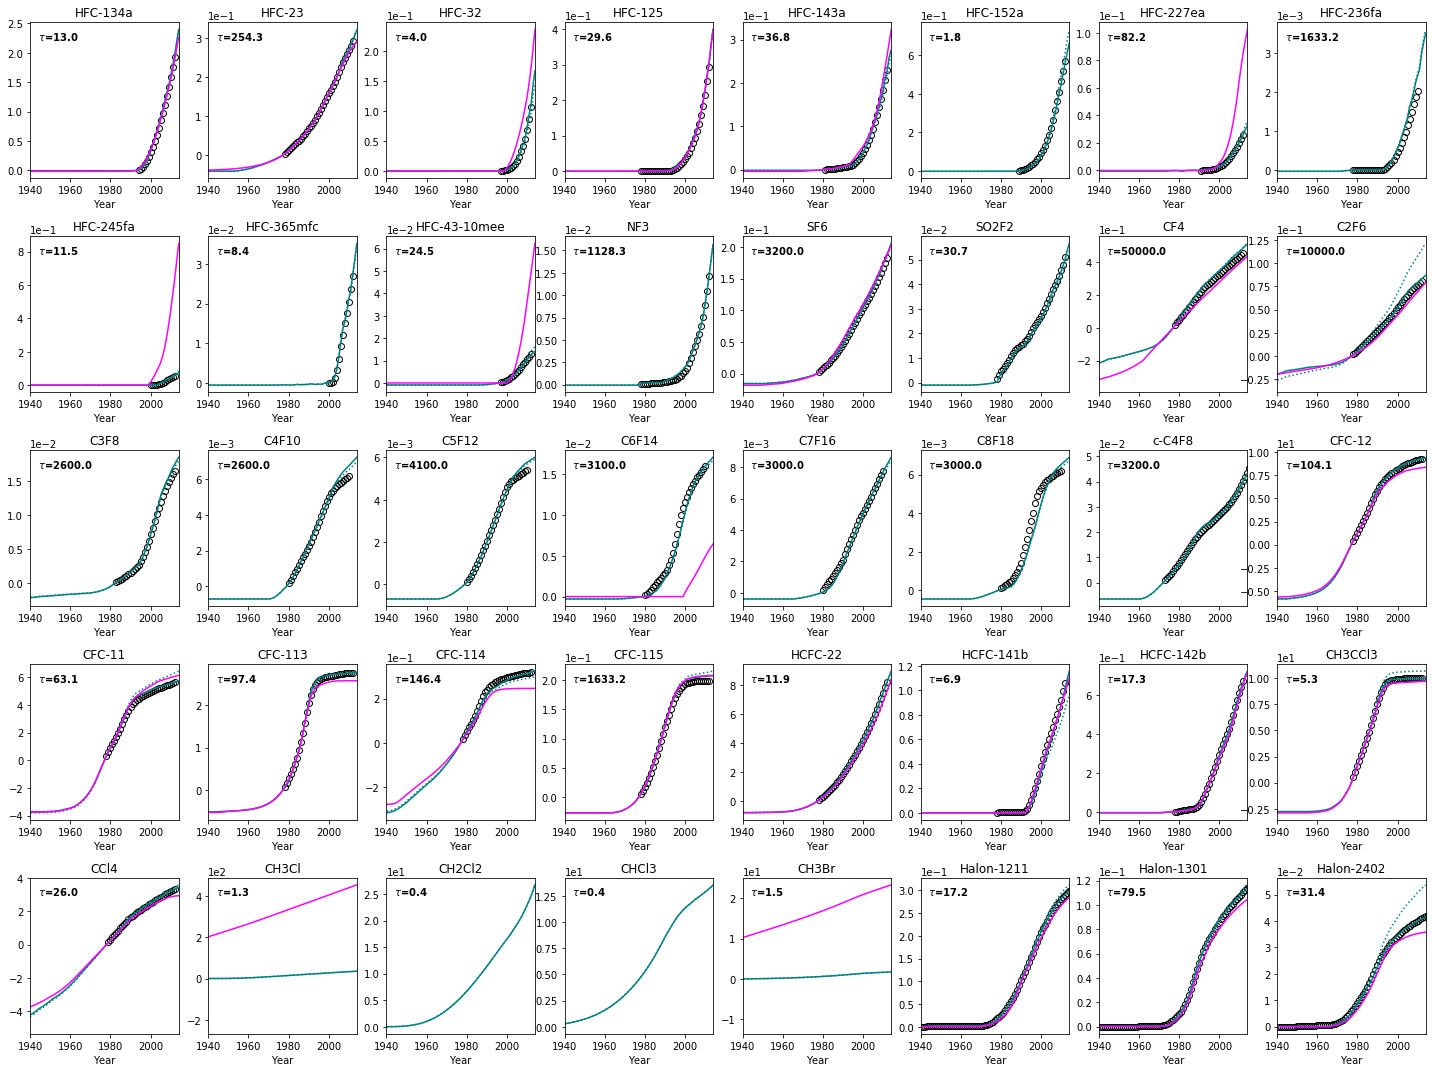

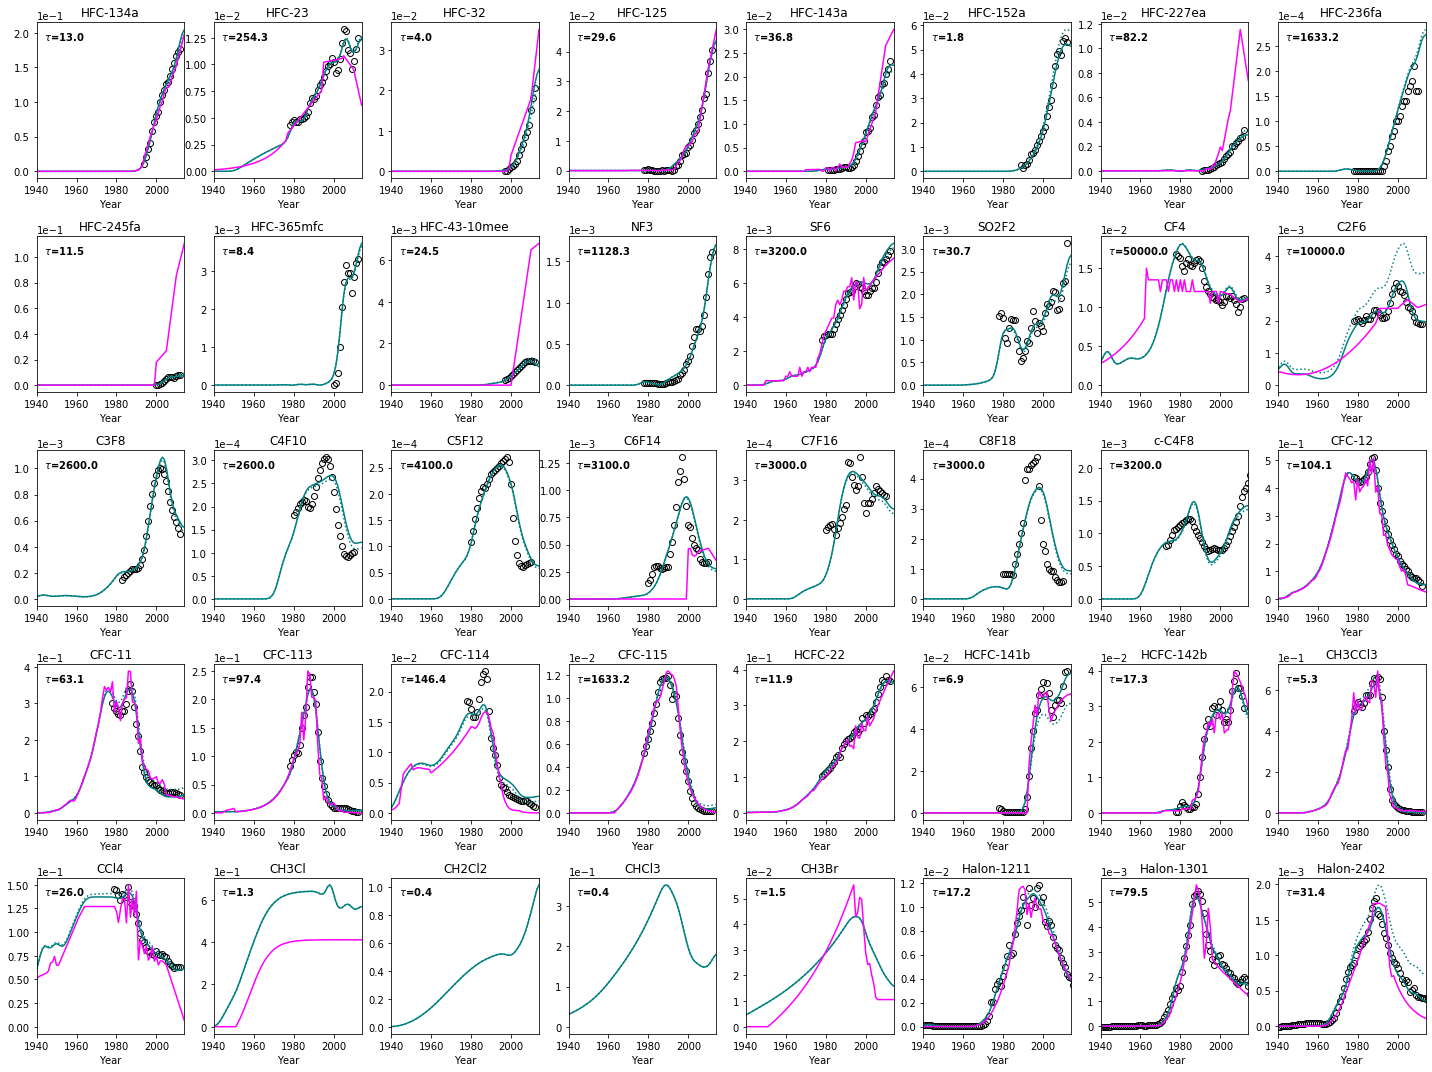

In [11]:
## Cumulative emission plots

multigas_result = run_UnFaIR(concentrations_in=concs_multigas_tune_run,forcing_in=forcing_multigas_tune_run,gas_parameters=tuned_params,show_run_info=False)
OG_multigas_result = run_UnFaIR(concentrations_in=concs_multigas_tune_run,forcing_in=forcing_multigas_tune_run,show_run_info=False,gas_parameters=pd.read_pickle('./Parameter_Sets/SPARC_HC-review_CMIP6-gas_parameters.p'))

RCP85_emissions = pd.read_csv('/home/leachl/Documents/Datasets/RCP_data/RCP85_EMISSIONS.csv',skiprows=36,index_col=0).loc[:2015]

RCP_2_CMIP6_names = {}

for cmip6name in multigas_result['Emissions'].columns.levels[-1]:
    bestmatch = ''
    bestscore = 0
    for RCPname in RCP85_emissions.columns:
        score = similar(RCPname,cmip6name)
        if score>bestscore:
            bestmatch = RCPname
            bestscore = score
            
    if bestscore > 0.5:
        RCP_2_CMIP6_names[cmip6name] = bestmatch
    else:
        RCP_2_CMIP6_names[cmip6name] = ''
        
for no_RCP_equiv in ['C3F8','C4F10','C5F12','C7F16','C8F18','CH2Cl2','CH3CCl3','CHCl3','CO2','HFC-152a','HFC-236fa','HFC-365mfc','NF3']:
    RCP_2_CMIP6_names[no_RCP_equiv] = ''
    
RCP_2_CMIP6_names['CCl4'] = 'CARB_TET'

RCP_2_CMIP6_names['CH3CCl3'] = 'MCF'

fig,ax = plt.subplots(5,8,figsize=(20,15))

for i,axes in enumerate(ax.flatten()):
    
    species = multigas_result['Emissions'].iloc[:,i+3].name[-1]
    
    if species in Hgas_inv_emms_dict.keys():
        start_cum_year = np.floor(Hgas_inv_emms_dict[species].index[0])-1
    else:
        start_cum_year = 1875
    
    axes.plot(multigas_result['Emissions'].xs(species,level=-1,axis=1).cumsum()-multigas_result['Emissions'].xs(species,level=-1,axis=1).cumsum().loc[start_cum_year],'teal')
    
    axes.plot(OG_multigas_result['Emissions'].xs(species,level=-1,axis=1).cumsum()-OG_multigas_result['Emissions'].xs(species,level=-1,axis=1).cumsum().loc[start_cum_year],':',color='teal')
        
    if species in Hgas_inv_emms_dict.keys():
        AGAGE_emissions = Hgas_inv_emms_dict[species]/1000
        AGAGE_emissions.index = (np.floor(Hgas_inv_emms_dict[species].index))
        (AGAGE_emissions.cumsum()).plot(ax=axes,color='k',marker='o',mfc='none',lw=0,legend=None,zorder=0)
        
    if RCP_2_CMIP6_names[species] != '':
        ((RCP85_emissions.loc[1800:2014,RCP_2_CMIP6_names[species]]/1000).cumsum()-(RCP85_emissions.loc[1800:2014,RCP_2_CMIP6_names[species]]/1000).cumsum().loc[start_cum_year]).plot(ax=axes,color='magenta')
    
    axes.set_xlim(1940,2014)
        
    axes.set_title(species)
    axes.set_xlabel('')
    axes.ticklabel_format(axis='y', style='sci',scilimits=(0,1))
    
    g1 = tuned_params.loc['tau1',('default',species)] * ( 1. - ( 1. + 100/tuned_params.loc['tau1',('default',species)] ) * np.exp(-100/tuned_params.loc['tau1',('default',species)]) )
    g0 = ( np.sinh( tuned_params.loc['tau1',('default',species)] * ( 1. - np.exp(-100/tuned_params.loc['tau1',('default',species)]) )  / g1 ) )**(-1.)
    
    alpha = g0 * np.sinh(tuned_params.loc['r0',('default',species)]/g1)
    
    axes.text(0.05, 0.95, r'$\tau$='+str(round(tuned_params.loc['tau1',('default',species)]*alpha,1)), ha='left',va='top', transform=axes.transAxes,fontweight='bold')
    
    axes.set_xlabel('Year')

plt.tight_layout()
fig.subplots_adjust(wspace=0.2)

# fig.savefig('./Final_figures/Other WMGHG inverse cumulative emissions.pdf')

# Annual emission plots

fig,ax = plt.subplots(5,8,figsize=(20,15))

for i,axes in enumerate(ax.flatten()):
    
    species = multigas_result['Emissions'].iloc[:,i+3].name[-1]
    
    axes.plot(multigas_result['Emissions'].index,sp.ndimage.filters.gaussian_filter(multigas_result['Emissions'].xs(species,level=-1,axis=1),2),'teal')
    
    axes.plot(multigas_result['Emissions'].index,sp.ndimage.filters.gaussian_filter(OG_multigas_result['Emissions'].xs(species,level=-1,axis=1),2),':',color='teal')
        
    if species in Hgas_inv_emms_dict.keys():
        AGAGE_emissions = Hgas_inv_emms_dict[species]/1000
        AGAGE_emissions.index = (np.floor(Hgas_inv_emms_dict[species].index))
        (AGAGE_emissions).plot(ax=axes,color='k',marker='o',mfc='none',lw=0,legend=None,zorder=0)
        
    if RCP_2_CMIP6_names[species] != '':
        ((RCP85_emissions.loc[1800:2014,RCP_2_CMIP6_names[species]]/1000)-(RCP85_emissions.loc[1800,RCP_2_CMIP6_names[species]]/1000)).plot(ax=axes,color='magenta')

    axes.set_xlim(1940,2014)
        
    axes.set_title(species)
    axes.ticklabel_format(axis='y', style='sci',scilimits=(0,1))
    
    g1 = tuned_params.loc['tau1',('default',species)] * ( 1. - ( 1. + 100/tuned_params.loc['tau1',('default',species)] ) * np.exp(-100/tuned_params.loc['tau1',('default',species)]) )
    g0 = ( np.sinh( tuned_params.loc['tau1',('default',species)] * ( 1. - np.exp(-100/tuned_params.loc['tau1',('default',species)]) )  / g1 ) )**(-1.)
    
    alpha = g0 * np.sinh(tuned_params.loc['r0',('default',species)]/g1)
    
    axes.text(0.05, 0.95, r'$\tau$='+str(round(tuned_params.loc['tau1',('default',species)]*alpha,1)), ha='left',va='top', transform=axes.transAxes,fontweight='bold')
    
    axes.set_xlabel('Year')

plt.tight_layout()
fig.subplots_adjust(wspace=0.2)

# fig.savefig('./Final_figures/Other WMGHG inverse annual emissions.pdf')

# Concentrations to RFs

## Fitting CO2, CH4, N2O to Etminan et al (2016)

CO2 f parameters (1,2,3): [ 4.92785926e+00  1.69275028e-03 -1.24327355e-02]
CH4 f parameters (1,2,3): [-3.32273289e-02 -7.88571938e-05  4.62953451e-02]
N2O f parameters (1,2,3): [0.05318862 0.00055362 0.08395515]


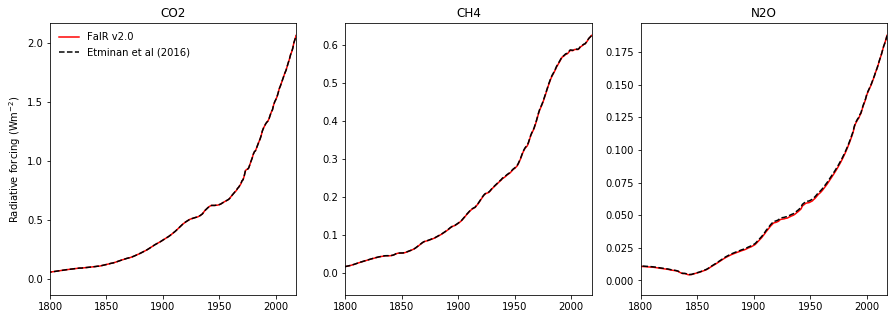

In [111]:
# Method: fit to historical non-interaction formulae, then add the difference at the present day to the appropriate terms

def Etminan(concs,interaction=True,PI_conc={'CO2':278,'CH4':720,'N2O':270}):
    
    interaction = int(interaction)
    
    forc_out = concs.copy()
    
    forc_out.loc[:,'CO2'] =  ( -2.4*10**(-7)*( concs.loc[:,'CO2'] - PI_conc['CO2'] )**2 +\
                              7.2*10**(-4)*abs( concs.loc[:,'CO2'] - PI_conc['CO2']) +\
                              interaction * ( -2.1*10**(-4)*0.5*(concs.loc[:,'N2O']+PI_conc['N2O']) ) +\
                              5.36 ) * np.log(concs.loc[:,'CO2'] / PI_conc['CO2']) ## CO2
    
    forc_out.loc[:,'CH4'] =  ( -1.3*10**(-6)*0.5*( concs.loc[:,'CH4'] + PI_conc['CH4'] ) +\
                              interaction * ( -8.2*10**(-6)*0.5*(concs.loc[:,'N2O']+PI_conc['N2O']) ) +\
                              0.043 ) * ( np.sqrt(concs.loc[:,'CH4']) - np.sqrt(PI_conc['CH4']) ) ## CH4
    
    forc_out.loc[:,'N2O'] =  ( 4.2*10**(-6)*0.5*( concs.loc[:,'N2O'] + PI_conc['N2O'] ) +\
                              interaction * ( -8*10**(-6)*0.5*(concs.loc[:,'CO2']+PI_conc['CO2']) ) +\
                              interaction * ( -4.9*10**(-6)*0.5*(concs.loc[:,'CH4']+PI_conc['CH4']) ) +\
                              0.117 ) * ( np.sqrt(concs.loc[:,'N2O']) - np.sqrt(PI_conc['N2O']) ) ## N2O
    
    return forc_out
    
Etminan_PI_conc = {}
for gas in ['CO2','CH4','N2O']:
    Etminan_PI_conc[gas] = TUNED_gas_cycle_params.loc['PI_conc',('default',gas)]
    
Etminan_no_interaction = Etminan(CMIP6_concs_extended,False,Etminan_PI_conc)
Etminan_interaction = Etminan(CMIP6_concs_extended,True,Etminan_PI_conc)

def fit_to_Etminan_NI(x,gas):
    
    fit_time_period = np.arange(1800,2019)
    
    fit_params = TUNED_gas_cycle_params.copy()
    
    fit_params.loc[['f1','f2','f3'],('default',gas)] = x
    
    fit_concs = pd.concat([CMIP6_concs_extended.loc[fit_time_period]],axis=1,keys=['RF_fit'])                   
    
    RF = run_UnFaIR(concentrations_in=fit_concs,gas_parameters=fit_params,show_run_info=False)['RF'].loc[:,('RF_fit','default','default',gas)]
    
    return np.sum((Etminan_no_interaction.loc[fit_time_period,gas] - RF)**2)

f_params_to_Etminan_NI = {}

fig,ax = plt.subplots(1,3,figsize=(15,5))

tuned_RF_params_NI = TUNED_gas_cycle_params.copy()
tuned_RF_params = TUNED_gas_cycle_params.copy()

for i,gas in enumerate(['CO2','CH4','N2O']):
    
    NI_fit = sp.optimize.minimize(fit_to_Etminan_NI,x0=TUNED_gas_cycle_params.loc[['f1','f2','f3'],('default',gas)],args=gas,method='Nelder-mead').x
    
    tuned_RF_params_NI.loc[['f1','f2','f3'],('default',gas)] = NI_fit
    
    ## Now add on the interaction terms at their present day values:
    
    if gas == 'CO2':
        NI_fit[0] += ( -2.1*10**(-4)*0.5*(CMIP6_concs_extended.loc[2018,'N2O']+Etminan_PI_conc['N2O']) )
    
    if gas == 'CH4':
        NI_fit[2] += ( -8.2*10**(-6)*0.5*(CMIP6_concs_extended.loc[2018,'N2O']+Etminan_PI_conc['N2O']) )
        
    if gas == 'N2O':
        NI_fit[2] += ( -8*10**(-6)*0.5*(CMIP6_concs_extended.loc[2018,'CO2']+Etminan_PI_conc['CO2']) ) + ( -4.9*10**(-6)*0.5*(CMIP6_concs_extended.loc[2018,'CH4']+Etminan_PI_conc['CH4']) )
        
    tuned_RF_params.loc[['f1','f2','f3'],('default',gas)] = NI_fit
    fit_concs = pd.concat([CMIP6_concs_extended],axis=1,keys=['RF_fit'])                   
    tuned_RF = run_UnFaIR(concentrations_in=fit_concs,gas_parameters=tuned_RF_params,show_run_info=False)['RF'].loc[:,('RF_fit','default','default',gas)]
    ax[i].plot(tuned_RF,'r',label='FaIR v2.0')
    ax[i].plot(Etminan_interaction.loc[:,gas],'k--',label='Etminan et al (2016)')
    
    ax[i].set_xlim(1800,2018)
    
    ax[i].set_title(gas)
        
    print(gas+' f parameters (1,2,3):',NI_fit)

ax[0].legend(frameon=False)
ax[0].set_ylabel('Radiative forcing (Wm$^{-2}$)')
# fig.suptitle('Etminan formulae vs best-fit modelled RF')

fig.savefig('./Final_figures/RF param fit to Etminan.pdf')

In [112]:
## Base RF parameter set addition:

TUNED_gas_cycle_params.loc[['f1','f2','f3'],('default',['CO2','CH4','N2O'])] = tuned_RF_params.loc[['f1','f2','f3'],('default',['CO2','CH4','N2O'])]

print('Tuned RF parameters:')
print()
TUNED_gas_cycle_params

Tuned RF parameters:



Gas_cycle_set         default                        
Gas                       CO2         CH4         N2O
param_name                                           
a1                   0.217300    1.000000    1.000000
a2                   0.224000    0.000000    0.000000
a3                   0.282400    0.000000    0.000000
a4                   0.276300    0.000000    0.000000
tau1           1000000.000000    9.150000  116.000000
tau2               394.400000    1.000000    1.000000
tau3                36.540000    1.000000    1.000000
tau4                 4.304000    1.000000    1.000000
r0                  28.627296    9.078874   67.843356
rC                   0.019773    0.000000    0.000000
rT                   4.334433   -0.287247    0.000000
rA                   0.000000    0.000343   -0.000999
PI_conc            278.000000  733.822081  271.258492
emis2conc            0.468952    0.351714    0.200980
f1                   4.927859   -0.033227    0.053189
f2                   0.001693   -0.000079    0.000554
f3                  -0.012433    0.046295    0.083955

O3 (T) linear forcing coefficient: 0.00036563925360562344
O3(S) linear forcing coefficient: -4.6156263279198264e-05
Vapour linear forcing coefficient: 6.911472824420556e-05


/home/leachl/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/home/leachl/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/home/leachl/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Text(0.5, 1.0, 'CH4 concentration perturbation regression vs. other feedbacks')

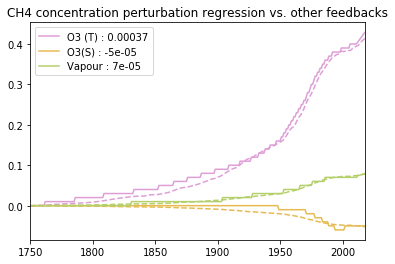

In [113]:
## Adding in CH4 oxidation to strat H2O plus Ozone as linear terms in the CH4 RF formula

fit_time_period = np.arange(1750,2019)

X = CMIP6_concs_extended.loc[fit_time_period,'CH4'] - TUNED_gas_cycle_params.loc['PI_conc',('default','CH4')]

for i,RF_agent in enumerate(['O3 (T)','O3(S)','Vapour']):
    
    Y = HIST_forc_PF.loc[fit_time_period,RF_agent]
    X = sm.add_constant(X)
    
    regression_model = sm.OLS(Y,X)
    regression_results = regression_model.fit()
    print(RF_agent+' linear forcing coefficient:',regression_results.params['CH4'])
    
    plt.plot(regression_results.params['CH4']*X['CH4'],color=plt.cm.tab20b(1/(i+1)),linestyle='--',label='')
    Y.plot(color=plt.cm.tab20b(1/(i+1)),linestyle='-',label=RF_agent+' : '+str(round(regression_results.params['CH4'],5)))

plt.legend()    
plt.title('CH4 concentration perturbation regression vs. other feedbacks')

In [114]:
TUNED_gas_cycle_params_CH4_feedbacks = TUNED_gas_cycle_params.copy()

TUNED_gas_cycle_params_CH4_feedbacks.loc['f2',('default','CH4')] += 0.00036563925360562344 - 4.6156263279198264e-05 + 6.911472824420556e-05

print('Parameters including CH4 RF feedbacks (strat H2O, Ozone (strat + trop))')
print()
TUNED_gas_cycle_params_CH4_feedbacks

Parameters including CH4 RF feedbacks (strat H2O, Ozone (strat + trop))



Gas_cycle_set         default                        
Gas                       CO2         CH4         N2O
param_name                                           
a1                   0.217300    1.000000    1.000000
a2                   0.224000    0.000000    0.000000
a3                   0.282400    0.000000    0.000000
a4                   0.276300    0.000000    0.000000
tau1           1000000.000000    9.150000  116.000000
tau2               394.400000    1.000000    1.000000
tau3                36.540000    1.000000    1.000000
tau4                 4.304000    1.000000    1.000000
r0                  28.627296    9.078874   67.843356
rC                   0.019773    0.000000    0.000000
rT                   4.334433   -0.287247    0.000000
rA                   0.000000    0.000343   -0.000999
PI_conc            278.000000  733.822081  271.258492
emis2conc            0.468952    0.351714    0.200980
f1                   4.927859   -0.033227    0.053189
f2                   0.001693    0.000310    0.000554
f3                  -0.012433    0.046295    0.083955

## Etminan fits over the RCP / SSP scenarios

In [151]:
## a demonstration of how well FaIR v2.0 does compared to Etminan for high emission future scenarios.

Etminan_PI_conc = {}
for gas in ['CO2','CH4','N2O']:
    Etminan_PI_conc[gas] = TUNED_gas_cycle_params.loc['PI_conc',('default',gas)]

Etminan_RCP_runs = {}
FaIR_RCP_RF_runs = {}
Etminan_RCP_runs_NI = {}
FaIR_RCP_RF_runs_NI = {}

for RCP in ['3PD','45','6','85']:
    Etminan_RCP_runs[RCP] = Etminan(RCP_data['C'][RCP][['CO2','CH4','N2O']],True,Etminan_PI_conc)
    Etminan_RCP_runs_NI[RCP] = Etminan(RCP_data['C'][RCP][['CO2','CH4','N2O']],False,Etminan_PI_conc)
    FaIR_RCP_RF_runs[RCP] = run_UnFaIR(concentrations_in=pd.concat([RCP_data['C'][RCP][['CO2','CH4','N2O']]],keys=[RCP],axis=1),gas_parameters=TUNED_gas_cycle_params,show_run_info=False)['RF'][RCP]['default']['default']
    FaIR_RCP_RF_runs_NI[RCP] = run_UnFaIR(concentrations_in=pd.concat([RCP_data['C'][RCP][['CO2','CH4','N2O']]],keys=[RCP],axis=1),gas_parameters=tuned_RF_params_NI,show_run_info=False)['RF'][RCP]['default']['default']

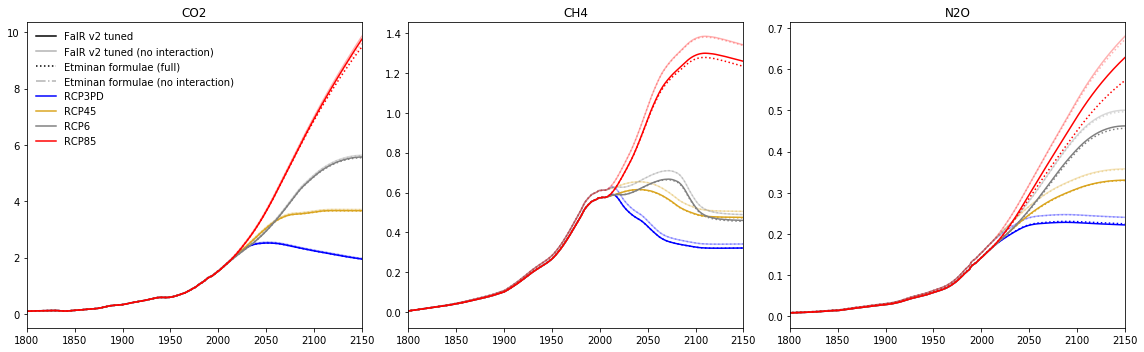

In [152]:
fig,ax = plt.subplots(1,3,figsize=(16,5))

RCP_colors = {'3PD':'blue','45':'goldenrod','6':'grey','85':'red'}

for i,gas in enumerate(['CO2','CH4','N2O']):
    
    for RCP in ['3PD','45','6','85']:

        ax[i].plot(FaIR_RCP_RF_runs[RCP][gas],color=RCP_colors[RCP],label='')
        ax[i].plot(FaIR_RCP_RF_runs_NI[RCP][gas],color=RCP_colors[RCP],label='',alpha=0.3)
        
        ax[i].plot(Etminan_RCP_runs[RCP][gas],color=RCP_colors[RCP],linestyle=':',label='')
        ax[i].plot(Etminan_RCP_runs_NI[RCP][gas],color=RCP_colors[RCP],linestyle=':',label='',alpha=0.3)
    
    ax[i].set_xlim(1800,2150)
    ax[i].set_title(gas)
    
# Make the legend
ax[0].plot(0,0,'k-',label='FaIR v2 tuned')
ax[0].plot(0,0,'k-',label='FaIR v2 tuned (no interaction)',alpha=0.3)
ax[0].plot(0,0,'k:',label='Etminan formulae (full)')
ax[0].plot(0,0,'k-.',label='Etminan formulae (no interaction)',alpha=0.3)
for RCP in ['3PD','45','6','85']:
    ax[0].plot(0,0,color=RCP_colors[RCP],label='RCP'+RCP)
ax[0].legend(frameon=False,loc='upper left')
    
plt.tight_layout()

# fig.suptitle('Radiative forcing (Wm$^{-2}$)',y=1.05,fontsize=15)

fig.savefig('./Final_figures/Etminan verification over RCPs.svg')

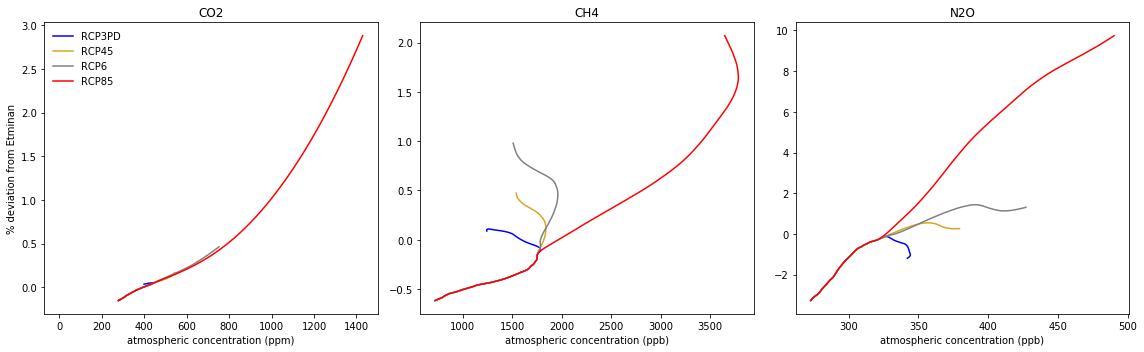

In [168]:
fig,ax = plt.subplots(1,3,figsize=(16,5))

RCP_colors = {'3PD':'blue','45':'goldenrod','6':'grey','85':'red'}
gas_conc_units = {'CO2':'ppm','CH4':'ppb','N2O':'ppb'}

for i,gas in enumerate(['CO2','CH4','N2O']):
    
    for RCP in ['3PD','45','6','85']:

        ax[i].plot(RCP_data['C'][RCP][gas],((FaIR_RCP_RF_runs[RCP][gas])/(Etminan_RCP_runs[RCP][gas])-1)*100,color=RCP_colors[RCP],label='')

#     ax[i].set_xlim(1800,2150)
    ax[i].set_title(gas)
    
    ax[i].set_xlabel('atmospheric concentration ('+gas_conc_units[gas]+')')

for RCP in ['3PD','45','6','85']:
    ax[0].plot(0,0,color=RCP_colors[RCP],label='RCP'+RCP)
ax[0].legend(frameon=False,loc='upper left')
ax[0].set_ylabel('% deviation from Etminan')

plt.tight_layout()

fig.savefig('./Final_figures/RF deviation versus Etminan over RCPs.svg')

# Thermal Model

TCR fit: [1.60171875]
ECS fit: [2.7529541]



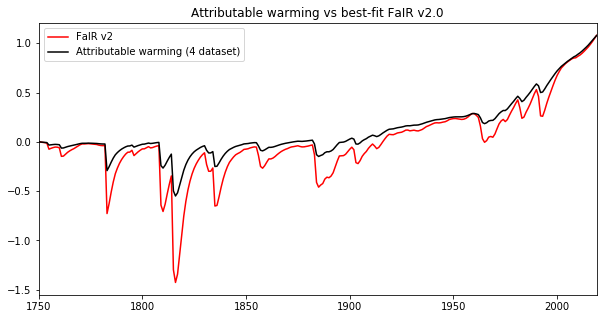

In [26]:
## Tuning thermal model to match attributable warming

forcing_for_fit = convert_forc_to_model_input(HIST_forc_PF['Total'],'tune_therm')

def tune_to_attributable_warming(x):
    
    thermal_params = default_thermal_params()
    
    scale_ecs = 2.75 / 1.6
    
    thermal_params.loc['tcr_ecs'] = [x , x * scale_ecs]
    
    model_temps = run_UnFaIR(emissions_in=return_empty_emissions(forcing_for_fit),forcing_in=forcing_for_fit,thermal_parameters=tcr_ecs_to_q(thermal_params),show_run_info=False)['T']
    
    return (Attributable_warming.loc[2017] - model_temps.loc[2017].values.flatten())**2

Thermal_fit = sp.optimize.minimize(tune_to_attributable_warming,x0=1.6,method='Nelder-mead')

TUNED_thermal_params = default_thermal_params()
scale_ecs = 2.75 / 1.6
# TUNED_thermal_params.loc['tcr_ecs'] = [Thermal_fit.x , Thermal_fit.x * scale_ecs]
TUNED_thermal_params.loc['tcr_ecs'] = [np.sqrt(2.5),2.66]

TUNED_model_temp_run = run_UnFaIR(emissions_in=return_empty_emissions(forcing_for_fit),forcing_in=forcing_for_fit,thermal_parameters=tcr_ecs_to_q(TUNED_thermal_params),show_run_info=False)['T']

print('TCR fit:', Thermal_fit.x)
print('ECS fit:', Thermal_fit.x * scale_ecs)
print()

fig,ax = plt.subplots(figsize=(10,5))
plt.plot(TUNED_model_temp_run,'r',label='FaIR v2')
plt.plot(Attributable_warming,'k',label='Attributable warming (4 dataset)')
plt.title('Attributable warming vs best-fit FaIR v2.0')
plt.xlim(1750,2019)
plt.legend()

Note that the high response to volcanoes is an artifact of the forcing dataset, but shouldn't matter for a fit to present-day temperatures due to the lack of recent eruptions

# Save the parameter sets

In [117]:
TUNED_gas_cycle_params.to_pickle('./Parameter_Sets/FaIRv2_gas-cycle-parameters_no-CH4-feedbacks_v1.p')
TUNED_gas_cycle_params_CH4_feedbacks.to_pickle('./Parameter_Sets/FaIRv2_gas-cycle-parameters_incl-CH4-feedbacks_v1.p')
# TUNED_thermal_params.to_pickle('./Parameter_Sets/FaIRv2_thermal-cycle-parameters_v1.p')
# TUNED_gas_cycle_param_uncertainties.to_pickle('./Parameter_Sets/FaIRv2_thermal-cycle-parameter-uncertainties_v1.p')

# Emission runs including uncertainties

In [73]:
# Generate some parameter ensembles uncertainties:

N = 199

# TCR ~ lognorm ; RWF ~ norm
TCR_samples = np.random.lognormal(np.log(2.5)/2,np.log(2.5)/(2*1.645),N)
RWF_samples = sp.stats.truncnorm(-2.75,2.75,loc=0.6,scale=0.15/1.645).rvs(N)
ECS_samples = TCR_samples/RWF_samples

d1_samples = sp.stats.truncnorm(-2.75,2.75,loc=239,scale=63).rvs(N)
d2_samples = sp.stats.truncnorm(-2.75,2.75,loc=4.1,scale=1).rvs(N)

# Put the distributions into a format readable by FaIR
thermal_param_template = default_thermal_params().default
thermal_param_template.loc['tcr_ecs'] = [np.sqrt(2.5),2.66]
thermal_param_list = [thermal_param_template]
for i in np.arange(N):    
    thermal_param_curr = thermal_param_template.copy()
    thermal_param_curr.loc['tcr_ecs'] = [TCR_samples[i],ECS_samples[i]]
    thermal_param_curr.loc['d'] = [d1_samples[i],d2_samples[i]]
    thermal_param_list += [thermal_param_curr]    
thermal_param_set = pd.concat(thermal_param_list,keys=['median']+['set'+str(x) for x in np.arange(N)],axis=1)

## Generate a gas cycle parameter set based on normally distributed parameters

gas_cycle_param_set = draw_monte_carlo_param_set(100,TUNED_gas_cycle_params,TUNED_gas_cycle_param_uncertainties)

## Calculate best-estimate non-CO2-CH4-N2O forcing

Observed_concs_run = pd.concat([CMIP6_concs_extended.loc[1750:]],keys=['Observed_run'],axis=1)

Observed_gas_forcing = run_UnFaIR(concentrations_in=Observed_concs_run,forcing_in=return_empty_forcing(Observed_concs_run),gas_parameters=TUNED_gas_cycle_params,thermal_parameters=tcr_ecs_to_q(default_thermal_params()))['RF']

Observed_other_forcing = HIST_forc_PF.Total - Observed_gas_forcing.loc[HIST_forc_PF.index,('Observed_run','default','default','Total')].values

Observed_other_forcing = convert_forc_to_model_input(Observed_other_forcing,'Observed_run')

## define period of simulation

simulation_period = np.arange(1750,2017)

Observational_model_run_plus_uncert = run_UnFaIR(emissions_in=Best_emission_estimates.loc[simulation_period],forcing_in=Observed_other_forcing.loc[simulation_period],\
                                                 gas_parameters=gas_cycle_param_set,thermal_parameters=tcr_ecs_to_q(thermal_param_set))

Integrating 1 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['CO2', 'CH4', 'N2O'], between 1750 and 2018...
Integrating 1 scenarios, 100 gas cycle parameter sets, 200 thermal response parameter sets, over ['CO2', 'CH4', 'N2O'], between 1750 and 2016...


/home/leachl/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:969: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_nested_tuple(tup)


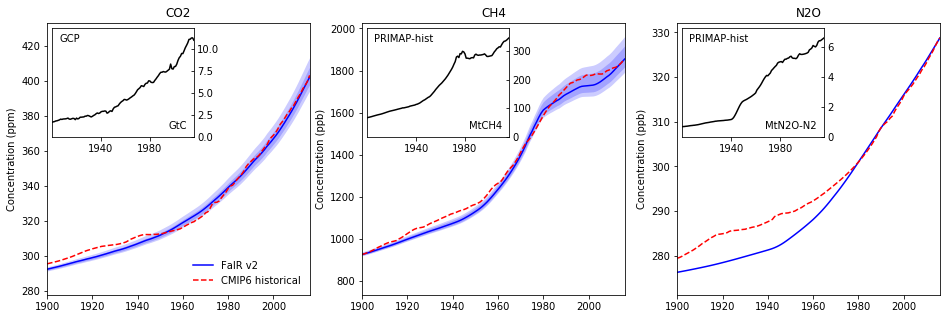

In [74]:
plot_xlim = np.arange(1900,2017)

fig,ax = plt.subplots(1,3,figsize=(16,5))

conc_units = {'CO2':'ppm','CH4':'ppb','N2O':'ppb'}
emms_units = {'CO2':'GtC','CH4':'MtCH4','N2O':'MtN2O-N2'}
emms_source = {'CO2':'GCP','CH4':'PRIMAP-hist','N2O':'PRIMAP-hist'}

for i,gas in enumerate(['CO2','CH4','N2O']):
    
    concs_to_plot = Observational_model_run_plus_uncert['C'].xs(gas,level=-1,axis=1).loc[plot_xlim]
    
    ax[i].fill_between(plot_xlim,concs_to_plot.quantile(0.83,axis=1),concs_to_plot.quantile(0.17,axis=1),color='b',alpha=0.2,linewidth=0)
    ax[i].fill_between(plot_xlim,concs_to_plot.quantile(0.95,axis=1),concs_to_plot.quantile(0.05,axis=1),color='b',alpha=0.2,linewidth=0)
    
    ax[i].plot(plot_xlim,concs_to_plot['default']['median']['median'],'b',label='FaIR v2')
    
    ax[i].plot(plot_xlim,CMIP6_concs_extended.loc[plot_xlim,gas],'r--',label='CMIP6 historical')
    
    ax[i].set_xlim(plot_xlim.min(),plot_xlim.max())
    ax[i].set_ylim(Observational_model_run_plus_uncert['gas_parameters'].loc['PI_conc',('median',gas)],concs_to_plot.max().max()*1.01)
    ax[i].legend(frameon=False,loc='upper left')
    ax[i].set_title(gas)
    ax[i].set_ylabel('Concentration ('+conc_units[gas]+')')
    ax[i].legend([],frameon=False)
    
    ax_ins = inset_axes(ax[i], width="54%", height="40%", loc=2)
    
    ax_ins.plot(plot_xlim,Best_emission_estimates.loc[plot_xlim,('default',gas)],'k')
    
    ax_ins.set_xlim(plot_xlim.min(),plot_xlim.max())
    ax_ins.set_ylim(0,Best_emission_estimates.loc[plot_xlim,('default',gas)].max()*1.1)
    ax_ins.yaxis.tick_right()
    ax_ins.set_xticks([1940,1980])
    ax_ins.tick_params(axis="y",direction="in")
    ax_ins.text(0.05, 0.95, emms_source[gas], ha='left',va='top', transform=ax_ins.transAxes)
    ax_ins.text(0.95, 0.05, emms_units[gas], ha='right',va='bottom', transform=ax_ins.transAxes)
    
ax[0].legend(frameon=False,loc='lower right')
    
fig.savefig('./Final_figures/Emission driven historical concentrations.pdf')

### Airbourne fraction uncertainties

(20, 55)

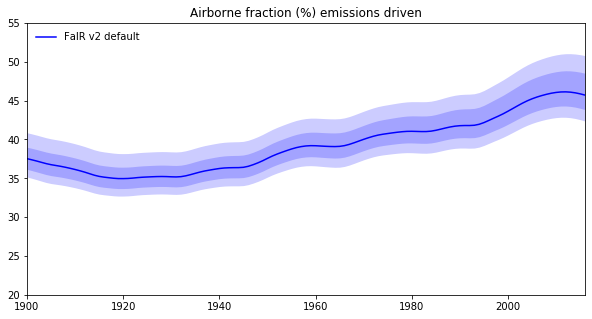

In [75]:
Observational_diagnosed_emissions = Best_emission_estimates.xs('CO2',level=-1,axis=1).loc[simulation_period].default
Observed_concs = Observational_model_run_plus_uncert['C'].xs('CO2',level=-1,axis=1).reindex(np.arange(1749,2017))
Observed_concs.loc[1749] = Observational_model_run_plus_uncert['gas_parameters']['median'].CO2.loc['PI_conc']
Observed_conc_change = Observed_concs.diff().loc[simulation_period]

plot_xlim = np.arange(1900,2017)

airbourne_frac_ensemble = 100*(Observed_conc_change/(Observational_diagnosed_emissions.values[:,np.newaxis]*Observational_model_run_plus_uncert['gas_parameters']['median'].CO2.loc['emis2conc'])).loc[plot_xlim]

fig,ax = plt.subplots(figsize=(10,5))

b, a = signal.butter(1, 0.05)

_83 = signal.filtfilt(b, a, airbourne_frac_ensemble.quantile(0.83,axis=1))
_17 = signal.filtfilt(b, a, airbourne_frac_ensemble.quantile(0.17,axis=1))
_95 = signal.filtfilt(b, a, airbourne_frac_ensemble.quantile(0.95,axis=1))
_05 = signal.filtfilt(b, a, airbourne_frac_ensemble.quantile(0.05,axis=1))

ax.fill_between(plot_xlim,_83,_17,color='b',alpha=0.2,linewidth=0)
ax.fill_between(plot_xlim,_95,_05,color='b',alpha=0.2,linewidth=0)

ax.plot(plot_xlim,signal.filtfilt(b, a, airbourne_frac_ensemble['default']['median']['median']),'b',label='FaIR v2 default')

ax.legend(loc='upper left',frameon=False)

ax.set_title('Airborne fraction (%) emissions driven')

ax.set_xlim(plot_xlim.min(),plot_xlim.max())

ax.set_ylim(20,55)

## Base parameters for comparison:

In [169]:
print('Preindustrial [1750] lifetimes:')

CH4_lifetime = Observational_model_run_plus_uncert['alpha'].xs(('default','CH4'),level=(0,3),axis=1).copy()
N2O_lifetime = Observational_model_run_plus_uncert['alpha'].xs(('default','N2O'),level=(0,3),axis=1).copy()
for gas_param_set in Observational_model_run_plus_uncert['gas_parameters'].columns.levels[0]:
    gas_set_tau = Observational_model_run_plus_uncert['gas_parameters'].loc['tau1',(gas_param_set,'CH4')]
    CH4_lifetime.loc[:,gas_param_set] = CH4_lifetime.loc[:,gas_param_set].values * gas_set_tau
    gas_set_tau = Observational_model_run_plus_uncert['gas_parameters'].loc['tau1',(gas_param_set,'N2O')]
    N2O_lifetime.loc[:,gas_param_set] = N2O_lifetime.loc[:,gas_param_set].values * gas_set_tau
    
print('CH4:',np.median(CH4_lifetime.loc[1750]),[np.percentile(CH4_lifetime.loc[1750],5),np.percentile(CH4_lifetime.loc[1750],95)])
print('N2O:',np.median(N2O_lifetime.loc[1750]),[np.percentile(N2O_lifetime.loc[1750],5),np.percentile(N2O_lifetime.loc[1750],95)])

print()

print('Present-day [2016] lifetimes:')
print('CH4:',np.median(CH4_lifetime.loc[2016]),[np.percentile(CH4_lifetime.loc[2016],5),np.percentile(CH4_lifetime.loc[2016],95)],\
     [np.percentile(CH4_lifetime.loc[2016,'median'],5),np.percentile(CH4_lifetime.loc[2016,'median'],95)]) # spread from climate uncertainty (around 20%)
print('N2O:',np.median(N2O_lifetime.loc[2016]),[np.percentile(N2O_lifetime.loc[2016],5),np.percentile(N2O_lifetime.loc[2016],95)])

print()

print('Effective natural emissions:')

CH4_natural_emissions = CH4_lifetime.loc[1750].copy()
N2O_natural_emissions = N2O_lifetime.loc[1750].copy()
for gas_param_set in Observational_model_run_plus_uncert['gas_parameters'].columns.levels[0]:
    CH4_natural_emissions.loc[gas_param_set] = Observational_model_run_plus_uncert['gas_parameters'].loc['PI_conc',(gas_param_set,'CH4')]/(CH4_natural_emissions.loc[gas_param_set].values*Observational_model_run_plus_uncert['gas_parameters'].loc['emis2conc',(gas_param_set,'CH4')])
    N2O_natural_emissions.loc[gas_param_set] = Observational_model_run_plus_uncert['gas_parameters'].loc['PI_conc',(gas_param_set,'N2O')]/(N2O_natural_emissions.loc[gas_param_set].values*Observational_model_run_plus_uncert['gas_parameters'].loc['emis2conc',(gas_param_set,'N2O')])

print('Preindustrial [1750] natural emissions:')
print('CH4:',np.median(CH4_natural_emissions),[np.percentile(CH4_natural_emissions,5),np.percentile(CH4_natural_emissions,95)])
print('N2O:',np.median(N2O_natural_emissions),[np.percentile(N2O_natural_emissions,5),np.percentile(N2O_natural_emissions,95)])

print()

print('Present-day [2016] iIRF100:')

tau = Observational_model_run_plus_uncert['gas_parameters'].loc['tau1':'tau4',('median','CO2')].values
a = Observational_model_run_plus_uncert['gas_parameters'].loc['a1':'a4',('median','CO2')].values
g1 = np.sum( a * tau * ( 1. - ( 1. + 100/tau ) * np.exp(-100/tau) ) )
g0 = ( np.sinh( np.sum( a * tau * ( 1. - np.exp(-100/tau) ) )  / g1 ) )**(-1.)
iIRF100_CO2 = Observational_model_run_plus_uncert['alpha'].xs(('default','CO2'),level=(0,3),axis=1).copy()
iIRF100_CO2 = np.arcsinh( iIRF100_CO2 / g0 ) * g1

print(np.median(iIRF100_CO2.loc[2016]),[np.percentile(iIRF100_CO2.loc[2016],5),np.percentile(iIRF100_CO2.loc[2016],95)],\
     [np.percentile(iIRF100_CO2.loc[2016,'median'],5),np.percentile(iIRF100_CO2.loc[2016,'median'],95)]) # spread from climate uncertainty

Preindustrial [1750] lifetimes:
CH4: 9.083472371492725 [8.73834611319864, 9.710036983227111]
N2O: 119.91747365626048 [119.43568191648988, 119.98429720777867]

Present-day [2016] lifetimes:
CH4: 10.199092585649574 [9.499919185249714, 11.246665808662227] [9.891337182079019, 10.314583258460877]
N2O: 118.52996002488364 [118.07603234842969, 118.87350035090412]

Effective natural emissions:
Preindustrial [1750] natural emissions:
CH4: 229.69365590124568 [214.872078211383, 238.76549143450677]
N2O: 11.255089352506467 [11.248820990212373, 11.300491319917853]

Present-day [2016] iIRF100:
40.49788930039142 [36.703812433460705, 45.24786139501406] [38.841544442624894, 42.70750183829996]


# Concentration runs including uncertainties

In [77]:
Observed_concs_run = pd.concat([CMIP6_concs_extended],keys=['Observed_run'],axis=1)

Observational_model_run_plus_uncert_conc_run = run_UnFaIR(concentrations_in=Observed_concs_run.loc[simulation_period],forcing_in=Observed_other_forcing.loc[simulation_period],\
                                                 gas_parameters=gas_cycle_param_set,thermal_parameters=tcr_ecs_to_q(thermal_param_set))

Integrating 1 scenarios, 100 gas cycle parameter sets, 200 thermal response parameter sets, over ['CO2', 'CH4', 'N2O'], between 1750 and 2016...


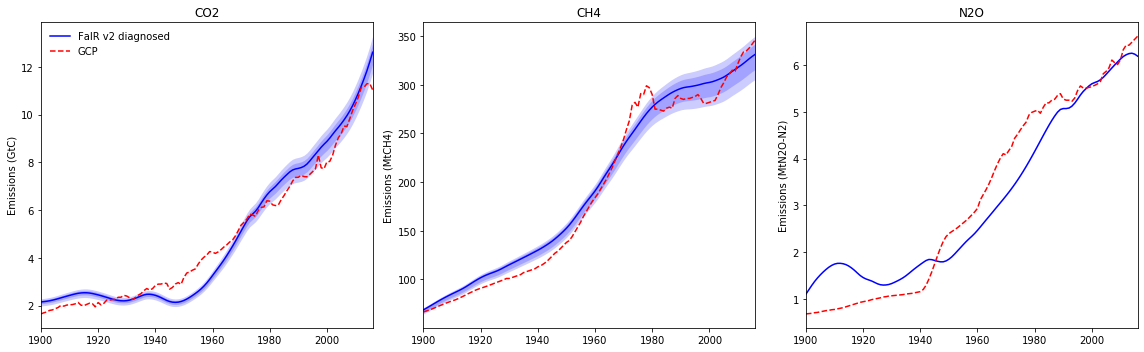

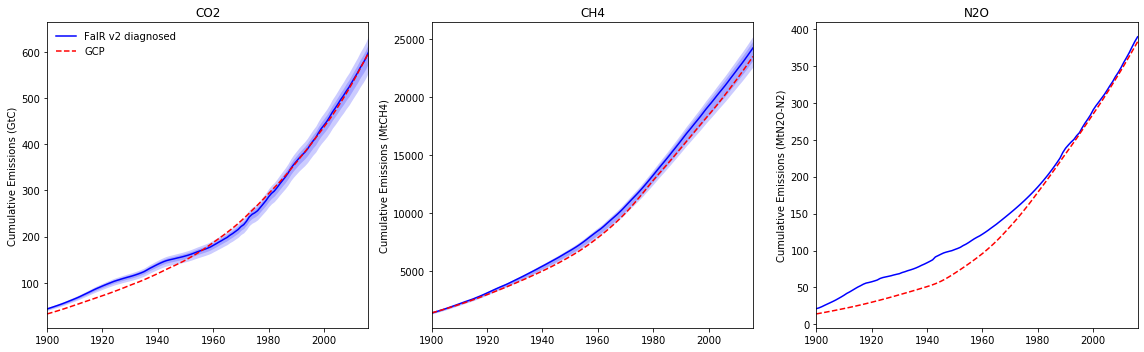

In [78]:
plot_xlim = np.arange(1900,2017)

fig,ax = plt.subplots(1,3,figsize=(16,5))

emms_units = {'CO2':'GtC','CH4':'MtCH4','N2O':'MtN2O-N2'}
emms_source = {'CO2':'GCP','CH4':'PRIMAP-hist','N2O':'PRIMAP-hist'}

for i,gas in enumerate(['CO2','CH4','N2O']):
    
    emms_to_plot = Observational_model_run_plus_uncert_conc_run['Emissions'].xs(gas,level=-1,axis=1).loc[plot_xlim]
    
    b, a = signal.butter(1, 0.05)
    
    _83 = signal.filtfilt(b, a, emms_to_plot.quantile(0.83,axis=1))
    _17 = signal.filtfilt(b, a, emms_to_plot.quantile(0.17,axis=1))
    _95 = signal.filtfilt(b, a, emms_to_plot.quantile(0.95,axis=1))
    _05 = signal.filtfilt(b, a, emms_to_plot.quantile(0.05,axis=1))
    
    ax[i].fill_between(plot_xlim,_83,_17,color='b',alpha=0.2,linewidth=0)
    ax[i].fill_between(plot_xlim,_95,_05,color='b',alpha=0.2,linewidth=0)
    
    ax[i].plot(plot_xlim,signal.filtfilt(b, a,emms_to_plot['Observed_run']['median']['median']),'b',label='FaIR v2 diagnosed')
    
    ax[i].plot(plot_xlim,Best_emission_estimates.loc[plot_xlim,('default',gas)],'r--',label=emms_source[gas])
    
    ax[i].set_xlim(plot_xlim.min(),plot_xlim.max())
    ax[i].set_title(gas)
    ax[i].set_ylabel('Emissions ('+emms_units[gas]+')')
    
ax[0].legend(frameon=False,loc='upper left')
    
plt.tight_layout()

fig.savefig('./Final_figures/Concentration driven historical annual emissions.pdf')
    
fig,ax = plt.subplots(1,3,figsize=(16,5))

for i,gas in enumerate(['CO2','CH4','N2O']):
    
    emms_to_plot = Observational_model_run_plus_uncert_conc_run['Emissions'].xs(gas,level=-1,axis=1).cumsum() - Observational_model_run_plus_uncert_conc_run['Emissions'].xs(gas,level=-1,axis=1).cumsum().loc[1875]
    
    _83 = emms_to_plot.quantile(0.83,axis=1).loc[plot_xlim]
    _17 = emms_to_plot.quantile(0.17,axis=1).loc[plot_xlim]
    _95 = emms_to_plot.quantile(0.95,axis=1).loc[plot_xlim]
    _05 = emms_to_plot.quantile(0.05,axis=1).loc[plot_xlim]
    
    ax[i].fill_between(plot_xlim,_83,_17,color='b',alpha=0.2,linewidth=0)
    ax[i].fill_between(plot_xlim,_95,_05,color='b',alpha=0.2,linewidth=0)

    ax[i].plot(plot_xlim,emms_to_plot['Observed_run']['median']['median'].loc[plot_xlim],'b',label='FaIR v2 diagnosed')
    
    ax[i].plot(plot_xlim,(Best_emission_estimates.loc[:,('default',gas)].cumsum()-Best_emission_estimates.loc[:,('default',gas)].cumsum().loc[1875]).loc[plot_xlim],'r--',label=emms_source[gas])
    
    ax[i].set_xlim(plot_xlim.min(),plot_xlim.max())
    ax[i].set_title(gas)
    ax[i].set_ylabel('Cumulative Emissions ('+emms_units[gas]+')')
    
ax[0].legend(frameon=False,loc='upper left')
    
plt.tight_layout()

fig.savefig('./Final_figures/Concentration driven historical cumulative emissions.pdf')

### Airborne fraction from emissions

(20, 55)

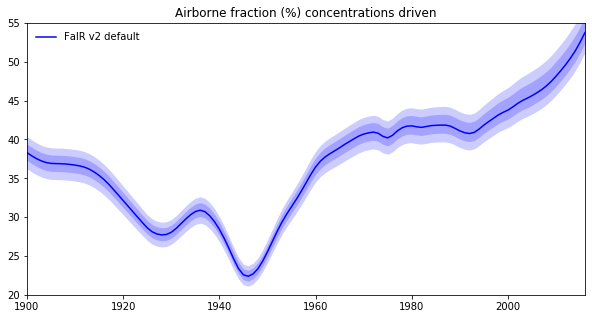

In [34]:
Observational_diagnosed_emissions = Observational_model_run_plus_uncert_conc_run['Emissions'].xs('CO2',level=-1,axis=1).loc[simulation_period]
Observed_concs = Observational_model_run_plus_uncert_conc_run['C'].xs('CO2',level=-1,axis=1).reindex(np.arange(1749,2017))
Observed_concs.loc[1749] = Observational_model_run_plus_uncert['gas_parameters']['median'].CO2.loc['PI_conc']
Observed_conc_change = Observed_concs.diff().loc[simulation_period]

plot_xlim = np.arange(1900,2017)

airbourne_frac_ensemble = 100*(Observed_conc_change.values/(Observational_diagnosed_emissions*Observational_model_run_plus_uncert['gas_parameters']['median'].CO2.loc['emis2conc'])).loc[plot_xlim]

fig,ax = plt.subplots(figsize=(10,5))

b, a = signal.butter(1, 0.05)

_83 = signal.filtfilt(b, a, airbourne_frac_ensemble.quantile(0.83,axis=1))
_17 = signal.filtfilt(b, a, airbourne_frac_ensemble.quantile(0.17,axis=1))
_95 = signal.filtfilt(b, a, airbourne_frac_ensemble.quantile(0.95,axis=1))
_05 = signal.filtfilt(b, a, airbourne_frac_ensemble.quantile(0.05,axis=1))

ax.fill_between(plot_xlim,_83,_17,color='b',alpha=0.2,linewidth=0)
ax.fill_between(plot_xlim,_95,_05,color='b',alpha=0.2,linewidth=0)

ax.plot(plot_xlim,signal.filtfilt(b, a, airbourne_frac_ensemble['Observed_run']['median']['median']),'b',label='FaIR v2 default')

ax.legend(loc='upper left',frameon=False)

ax.set_title('Airborne fraction (%) concentrations driven')

ax.set_xlim(plot_xlim.min(),plot_xlim.max())

ax.set_ylim(20,55)

# Appendices